In [1]:
# import packages
import sys
import os.path
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set()

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [ ]:
# cell to start up holoviews
import holoviews as hv

import scipy as sp

hv.extension('bokeh')

In [ ]:
# cell to test and make sure holoviews and bokeh are working
coords = np.random.rand(50,2)
points = hv.Points(coords)

points.opts(color='k', marker='+', size=10)

In [169]:
# cell to read real-time hdf5 file

#12-17, bill run session 3
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20191217_bill_05_r3_westerlies_streaming.rec_merged.h5'

#12-22, bill run session 
#hdf_file = '/stelmo/mcoulter/bill/raw/20191222/spykshrk_realtime_rec_files/20191222_bill_02_r1_westerlies_streaming.rec_merged.h5'

#1-17, remy day 20, epoch 2, 15 tets, ~1 hour
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_posterior_sum_1_16_1.rec_merged.h5'

#1-20, remy, day 20 , epoch 2, 15 tets, 100 uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_decoder_15tet_1_20_100uV_decode.rec_merged.h5'

#1-20, remy, day 20 , epoch 2, 19 tets, 150 uV
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_22_no_timer.rec_merged.h5'

# whole session remy, posterior sum from 9-14, 150 uV?
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/runs_on_drought/test_single_MEC.rec_merged_posterior_sum.h5'

# remy, 2 minutes trodesconf with 100 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_60uV.rec_merged.h5'

# remy, 2 minutes trodeconf with 60 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100uV.rec_merged.h5'

# remy, 2 minutes trodeconf with 60 uV spike threshold
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_100.rec_merged.h5'

# old spyskhrk code from 9-2019
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_150_sept_2019.rec_merged.h5'

# old trodes config file - no LFP ref
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_150_new_config.rec_merged.h5'

# same 2 minutes run on westerlies
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20200124_remy_5tet_westerlies.rec_merged.h5'

# 2 tets LFP and decode greenflash
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_24_100_2_tets.rec_merged.h5'

# ripple test 12-04 greenflash (tets 28 and 30)
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191204_4_greenflash_ripple.rec_merged.h5'

# tetrode 4 only greenflash 7-20-19
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/test_single_MEC.rec_merged_4_only.h5'

# origin_header 10-25-19 on greenflash
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/test_single_MEC_origin_header.rec_merged.h5'

# ripple 02 greenflash 11-02-19
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191102_greenflash_ripple_02.rec_merged.h5'

# 12-02 greenflash (tets 28 and 30)
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/output/20191202_2_greenflash_ripple.rec_merged.h5'

# 10-18 15 min playback on drought
#hdf_file = '/stelmo/mcoulter/spykshrk_realtime_vortex/runs_on_drought/test_single_MEC.rec_merged_15min_playback_1018.h5'

# 1-26 2 min playback new on drought
#hdf_file = '/stelmo/mcoulter/spykshrk_output/drought/test_single_MEC_drought_12_1_26.rec_merged.h5'

# bill 12-18-19 r1 - westerlies
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/20191218_bill_02_r1_westerlies_streaming.rec_merged.h5'

# 1-27 2 min greenflash old trodes
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_spike_thresh_1_27_old_trodes.rec_merged.h5'

# 1-27 old trodes 19 tets on westerlies, 30 min
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_27_old_trodes.rec_merged.h5'

# 1-31 remy, westerlies, new posterior sum
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_1_31_new_post_sum.rec_merged.h5'

# 2-2 remy westerlies, decoder with 1 bin delay
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_2_decoder_next_bin.rec_merged.h5'

# 2-2 remy westerlies, decoder with 1 bin delay
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_2_new_post_sum.rec_merged.h5'

# 2-3 remy test greenflash - changing ripple numbering
hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_1_30_test_running_sum_1.rec_merged.h5'

store = pd.HDFStore(hdf_file, mode='r')

In [64]:
# cell to fill in dataframes with realtime data
encoder_data = store['rec_3']
decoder_data = store['rec_4']
decoder_missed_spikes = store['rec_5']
likelihood_data = store['rec_6']
ripple_data = store['rec_1']
#stim_state = store['rec_10']
stim_lockout = store['rec_11']
stim_message = store['rec_12']
timing = store['rec_100']

In [79]:
# cell to fill in dataframes with realtime data
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
likelihood_data1 = store['rec_6']
ripple_data1 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
#timing1 = store['rec_100']

In [108]:
# cell to fill in dataframes with realtime data
encoder_data2 = store['rec_3']
decoder_data2 = store['rec_4']
decoder_missed_spikes2 = store['rec_5']
likelihood_data2 = store['rec_6']
ripple_data2 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout2 = store['rec_11']
stim_message2 = store['rec_12']
timing2 = store['rec_100']

In [170]:
# check new ripple numbering
encoder_data3 = store['rec_3']
decoder_data3 = store['rec_4']
decoder_missed_spikes3 = store['rec_5']
likelihood_data3 = store['rec_6']
ripple_data3 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout3 = store['rec_11']
stim_message3 = store['rec_12']
timing3 = store['rec_100']

(1128856, 141)


(array([    0., 53069.,  9379.,  4705.,  2489.,  1222.,   479.,   145.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

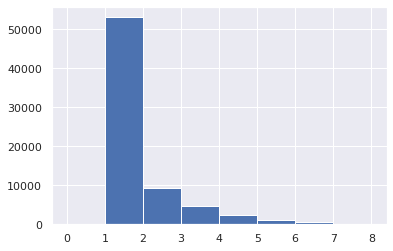

In [90]:
print(encoder_data.shape)
decoder_missed_spikes.shape
plt.hist(decoder_missed_spikes['late_bin'].values-decoder_missed_spikes['real_bin'].values,bins=np.arange(0,9))

In [89]:
np.sum(decoder_data1['spike_count'].values)

1281864

(1344905, 141)


(array([    0., 44339.,  9058.,  4910.,  2782.,  1352.,   458.,   128.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

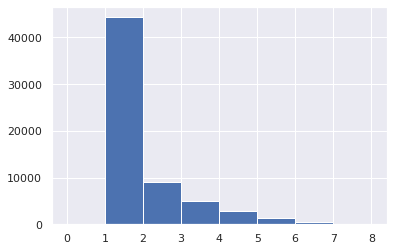

In [91]:
print(encoder_data1.shape)
decoder_missed_spikes1.shape
plt.hist(decoder_missed_spikes1['late_bin'].values-decoder_missed_spikes1['real_bin'].values,bins=np.arange(0,9))

In [277]:
encoder_data19.shape
timing19[timing19['label']=='enc_recv'].shape
(ripple_data5[ripple_data5['elec_grp_id']==10].shape[0])/1

(1900445, 8)

In [ ]:
# loop to print number of marks per tetrode
spikes_in_from_trodes = timing15[timing15['label']=='enc_recv']
for i in np.arange(1,31):
    print(i, encoder_data17[encoder_data17['elec_grp_id']==i].shape)
#    remy: 4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30
# bill: 1,4,5,6,9,10,16,17,18,20,21,24,25,27,28,29,30

In [ ]:
# need to go back to timing notebook to see how i plotted the timing delay in the lfp nodes
timing1[timing1['label'] == 'rip_recv']

In [ ]:
# look at how many lines per ripple in stim_message
stim_message1['next_ripple']=stim_message1['ripple_number'].diff()
stim_message1

<IPython.core.display.Javascript object>


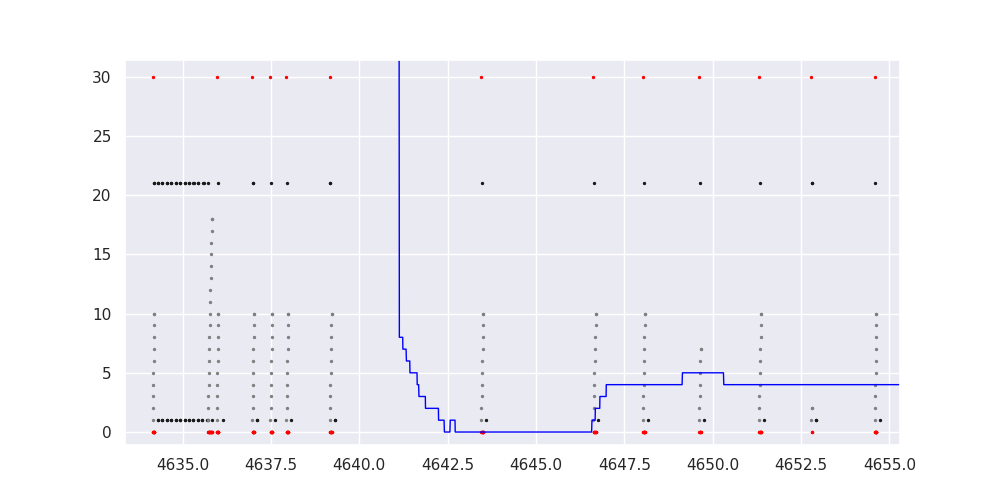

In [14]:
%matplotlib notebook

# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*20)+1,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)

# plot next ripple transitions and ripple time bin
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['next_ripple'].values)*30)+0,c='red',s=2)
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['ripple_time_bin'].values)*1)+0,c='grey',s=2)


In [ ]:
#adjust timestamp in realtime decoder_data to match offline timestamps
# actual shift is 1958987
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000
#df1 = df1.assign(adj_timestamp=e.values)
decoder_data_adj_ts.shape

# load offline data: posterior, position, and ripples

In [5]:
#this is the most recent offline decode
file_path = '/stelmo/mcoulter/oct_2019_decoding/remy_20_2_shuffle_0_posteriors_functionalized_150_decode_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [6]:
# get linear position for offline

#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
tetlist = [4]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0

shift_amt_for_shuffle = 0

use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks

discrete_tm_val=.99   # for classifier

# IMPORT and process data

#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)

# Import trials
trials = datasrc.import_trials()

# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'
linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
track_segment_ids = np.load(lin_output2)
print('Linearization found. Loading it')


#if os.path.exists(lin_output1) == False:
#    print('Linearization result doesnt exist. Doing linearization calculation')
#    sungod_util.run_linearization_routine(rat_name, day, epoch, linearization_path, raw_directory, gap_size=20)
#    linear_pos_raw['linpos_flat'] = np.load(lin_output1)
#    track_segment_ids = np.load(lin_output2)
#else: 

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))

Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  42]
 [ 47  59]
 [ 65  77]
 [ 82  94]
 [ 99 111]
 [116 128]
 [133 145]]
Rips less than velocity thresh: 1256


In [ ]:
# add linear position to offline posterior table
post_to_merge1 = posteriors2.copy()
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']
pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)
#pos_vel2
posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')


In [ ]:
#create posterior_to_plot
#posterior_offline = posteriors1.reset_index()
posterior_offline = posteriors2.reset_index()

# end of session - compared to real-time looking for arm 2 bias 154653600-157081200
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 154653600+1960000) & (posterior_offline['timestamp'] < 157081200+1960000)]

#this is a nice run down arm 7
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]

#this is a nice run down arm 5
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 103960800) & (posterior_offline['timestamp'] < 104769750)]
#offline_pos_to_plot = posterior_with_pos_vel[(posterior_with_pos_vel['timestamp1'] > 103960800) & (posterior_with_pos_vel['timestamp1'] < 104769750)]

#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3742.45) & (posterior_offline['time'] < 3742.55)]
# whole trial 60
#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3715) & (posterior_offline['time'] < 3755)]

#trial 60 replay 1
posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3729) & (posterior_offline['time'] < 3730.4)]

print(posterior_to_plot.shape)

In [ ]:
#create decoder_to_plot
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000

stim_lockout_adj_ts = stim_lockout.copy()
stim_lockout_adj_ts['adj_timestamp'] = stim_lockout_adj_ts['timestamp']+1960000

# shadow trials of arm 6 116141100 - 120145200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 116141100) & (decoder_data_adj_ts['timestamp'] < 120145200)]

# end of session strong bias to arm 2 154653600-157081200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 154653600) & (decoder_data_adj_ts['timestamp'] < 157081200)]

# a nice run down arm 7 - hmmm this doesnt look clear on the realtime decoder
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['adj_timestamp'] > 47598850) & (decoder_data_adj_ts['adj_timestamp'] < 48921150)]

print(decoder_to_plot.shape)
print(stim_to_plot.shape)

In [ ]:
# get ripple times from offline posteriors dataframe
ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1957500
#closest value lookup, return row
decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
for i in np.arange(1,ripple_timestamps.shape[0]):
    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
decoder_ripple_times.shape
#decoder_ripple_times.index.tolist()

In [ ]:
# offline posteriors, 150 uV threshold
# trial 60 - middle ripples - larger range is whole trial
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
import seaborn as sns
sns.set()

#posterior_offline = posteriors1.reset_index()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] == 1386].tolist()
#ripple_start = ripple_times[0] - posterior_to_plot.index[0]
#print(ripple_start)
#ripple_end = ripple_times[-1] - posterior_to_plot.index[0]
#print(ripple_end)

posterior_offline1 = posterior_to_plot.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
#posterior_offline1 = posterior_offline.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
posterior_offline2 = posterior_offline1.fillna(0)
post_heatmap = posterior_offline2.transpose()

# to only plot a few position bins
#post_heatmap = posterior_offline2.transpose()[0:20]

#post_heatmap = posterior_offline2[425005:426825].transpose()
#replay 1
#post_heatmap = posterior_only[486533:486733].transpose()
#replay 2
#post_heatmap = posterior_only[487356:487776].transpose()

post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
#ax.scatter(np.arange(0,offline_pos_to_plot.shape[0]),145-offline_pos_to_plot['linpos_flat'].values,s=1,alpha=0.05,color='cyan')
#ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())

#ax.vlines([ripple_start],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#ax.vlines([ripple_end],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#sns.heatmap(post_hist1[50000:55000],vmin=0, vmax=0.5)

In [5]:
sent_messages = stim_message[stim_message['stim_sent']==1]
sent_messages.set_index('bin_timestamp',inplace=True)
sent_messages
sent_messages_list = sent_messages.index.tolist()
sent_messages_array = np.array(sent_messages_list)
sent_messages_array-205127550
stim_message

,rec_ind,bin_timestamp,spike_timestamp,time,stim_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,67,174627300,174627480,1.576634e+09,0,1,1,10,0.8,1,1.000000,1.696804e-12,1.696804e-12,1.696804e-12,1.696804e-12,0.0,0.0,0.0,0.0
1,68,174627450,174627687,1.576634e+09,0,1,2,10,0.8,1,1.000000,2.949205e-08,2.949205e-08,2.949205e-08,2.949205e-08,0.0,0.0,0.0,0.0
2,69,174627600,174627796,1.576634e+09,0,1,3,10,0.8,1,1.000000,6.108996e-13,6.108996e-13,6.108996e-13,6.108996e-13,0.0,0.0,0.0,0.0
3,70,174627750,174628019,1.576634e+09,0,1,4,10,0.8,1,1.000000,2.199745e-08,2.199745e-08,2.199745e-08,2.199745e-08,0.0,0.0,0.0,0.0
4,71,174627900,174628067,1.576634e+09,0,1,5,10,0.8,1,1.000000,2.178247e-08,2.178247e-08,2.178247e-08,2.178247e-08,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49415,212243,282168000,282168796,1.576637e+09,0,632,68,10,0.6,1,0.034884,2.790565e-02,7.811054e-01,2.177018e-02,1.343345e-01,0.0,0.0,0.0,0.0
49416,212244,282168150,282168796,1.576637e+09,0,632,69,10,0.6,1,0.036483,2.968791e-02,7.757833e-01,2.360332e-02,1.344428e-01,0.0,0.0,0.0,0.0
49417,212245,282168300,282168796,1.576637e+09,0,632,70,10,0.6,1,0.038063,3.145882e-02,7.704735e-01,2.542456e-02,1.345801e-01,0.0,0.0,0.0,0.0
49418,212246,282168450,282168796,1.576637e+09,0,632,71,10,0.6,1,0.039627,3.321807e-02,7.651753e-01,2.723383e-02,1.347454e-01,0.0,0.0,0.0,0.0


In [18]:
# use pandas merge_asof to merge stim message into decoder data, then you can plot the ripples and stim messages
# on the heatmap of the posterior
# merge on bin_timestamp, do this before index is reset
# forward direction for merge extends 0 periods and keeps 1 as a short time (stim msssage sent)

stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim


,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x65,x66,x67,x68,x69,x70,x71,x72,stim_sent,posterior_max_arm
0,1,174433200,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,0.0,10.0
1,2,174433500,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,0.0,10.0
2,3,174433650,1.576634e+09,314.011683,0.0,0,0,0,0,0,...,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,0.0,10.0
3,5,174433950,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,0.0,10.0
4,6,174434100,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576860,643613,282481950,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.744892e-02,5.744098e-02,6.667936e-02,5.923395e-02,4.663491e-02,2.680227e-02,1.582633e-02,6.205174e-03,NaN,NaN
576861,643614,282482100,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.251042e-02,6.760395e-02,7.598804e-02,7.337274e-02,5.423333e-02,2.692719e-02,1.516381e-02,6.014564e-03,NaN,NaN
576862,643615,282482250,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.231307e-02,7.152026e-02,8.901394e-02,8.887999e-02,6.138022e-02,2.911804e-02,1.503579e-02,6.070540e-03,NaN,NaN
576863,643616,282482400,1.576637e+09,3.478607,1.0,0,0,0,0,0,...,5.074662e-02,6.733201e-02,8.276635e-02,7.940546e-02,5.955334e-02,3.507809e-02,1.674601e-02,9.107033e-03,NaN,NaN


In [25]:
# use pandas merge_asof to merge stim lockout into decoder data, this will plot decode heatmap and start of ripple
# merge on bin_timestamp, do this before index is reset
# backward direction for merge marks ripples with lockout_state = 1
# this looks like it works as exepcted
# BUT: the timestamps are not quite the same, the stim_lockout timestamps are LFP timestamps not decoder timestamps

stim_lockout_1 = stim_lockout1.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout1['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(decode_to_merge,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x64,x65,x66,x67,x68,x69,x70,x71,x72,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,3.251357e-04,3.037774e-04,2.890457e-04,2.755001e-04,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,4.269254e-04,4.036860e-04,3.872346e-04,3.716133e-04,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,5.156281e-04,5.030820e-04,4.847491e-04,4.738398e-04,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,6.103108e-04,5.977468e-04,5.838963e-04,6.075143e-03,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,0.0


In [41]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x132,x133,x134,x135,x136,shortcut_message_sent,ripple_number_y,posterior_max_arm,ripple_end,lockout_state
0,2,39691950,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,0,0,99,1,NaN
1,4,39692100,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,0,0,99,1,NaN
2,6,39692250,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,2,...,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,0,0,99,1,NaN
3,8,39692400,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,0,0,99,1,NaN
4,10,39692550,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,0,0,99,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563016,1195008,144173100,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,5.569374e-07,8.030340e-07,1.425664e-08,1.393337e-07,7.360622e-09,0,452,99,0,1.0
563017,1195010,144173250,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,3,...,2.161892e-06,1.144642e-05,2.484156e-07,1.103664e-06,2.947634e-07,0,452,99,0,1.0
563018,1195012,144173550,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,8.438110e-05,7.591057e-05,8.039253e-05,8.024402e-05,1.068855e-04,0,452,99,0,1.0
563019,1195014,144173700,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,2,...,1.769158e-07,8.673799e-06,2.551450e-06,1.203729e-05,1.000132e-05,0,452,99,0,1.0


<IPython.core.display.Javascript object>


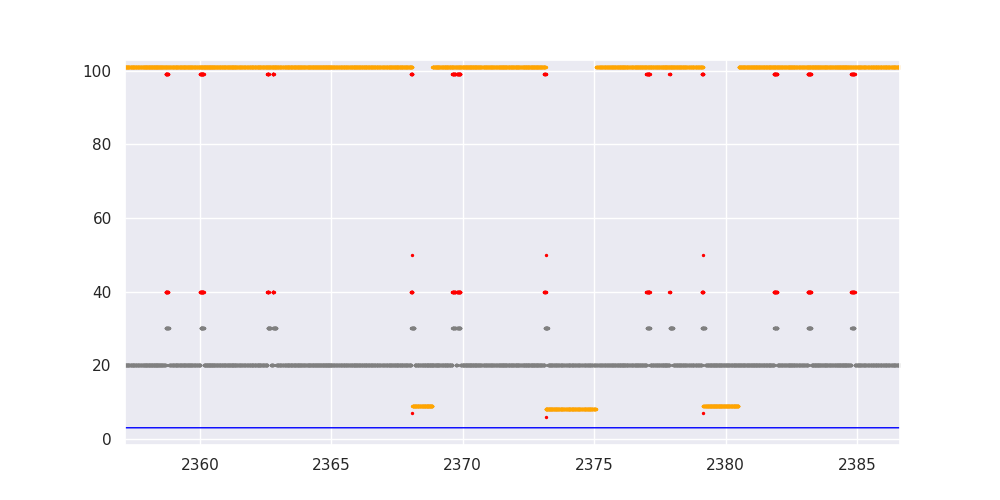

In [42]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['posterior_max_arm'].values)*1)+0,c='red',s=2)
##plot lockout time
#plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['posterior_max_arm'].values)*1)+2,c='orange',s=2)
## merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


In [14]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
#decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x68,x69,x70,x71,x72,lfp_timestamp,shortcut_message_sent,posterior_max_arm,ripple_end,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,126606240.0,0.0,99.0,1.0,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,126606240.0,0.0,99.0,1.0,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,138073420.0,0.0,99.0,0.0,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,138073420.0,0.0,99.0,0.0,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,138073420.0,0.0,99.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,NaN,NaN,NaN,NaN,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,NaN,NaN,NaN,NaN,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,NaN,NaN,NaN,NaN,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,NaN,NaN,NaN,NaN,0.0


<IPython.core.display.Javascript object>


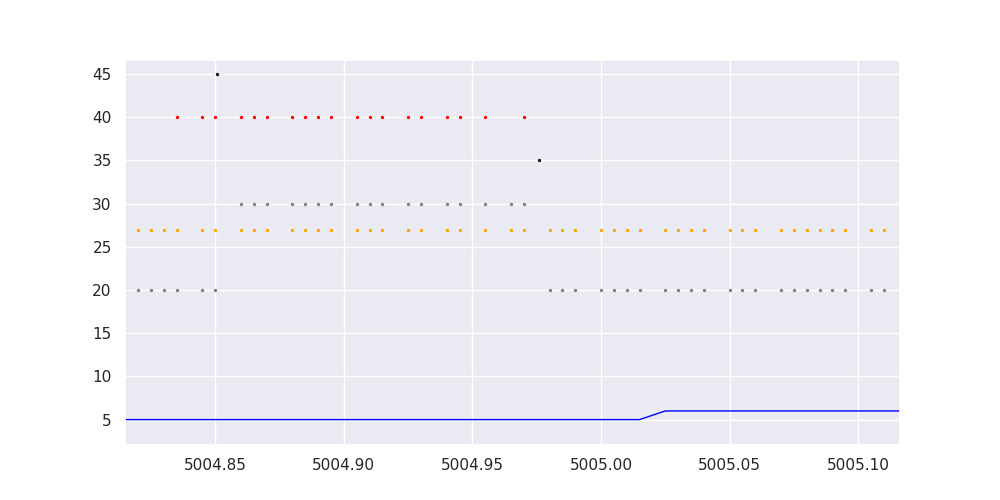

In [20]:
%matplotlib notebook
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['shortcut_message_sent'].values)*10)+27,c='orange',s=2)
# merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


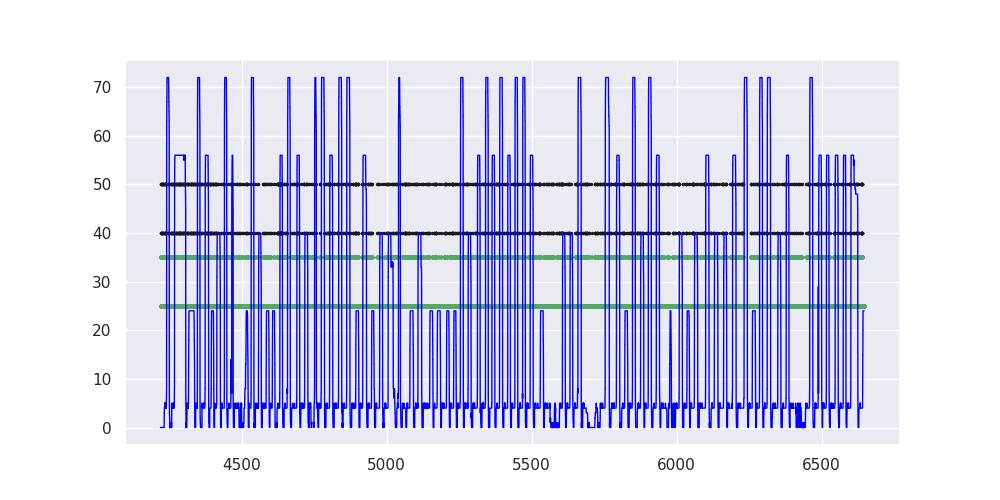

In [27]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [ ]:
plt.scatter(merged_decoder_stim['bin_timestamp'][9700:10000].values/30000,merged_decoder_stim['stim_sent'][9700:10000].values)
#plt.scatter(stim_message['bin_timestamp'][1000:1300].values/30000,stim_message['stim_sent'][1000:1300].values)


In [23]:
# subset of decoder_data to plot
#decoder_to_plot = decoder_data[(decoder_data['bin_timestamp'] > 205127400) & (decoder_data['bin_timestamp'] < 205636350)]
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#posterior_only = decoder_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
#                                       'spike_count','ripple','ripple_number','ripple_length',
#                                      'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
#                                      'arm6','arm7','arm8'], axis=1)

#posterior from decode/stim message merged table
merged_to_plot = merged_decoder_stim[(merged_decoder_stim['bin_timestamp'] > 205127400) & (merged_decoder_stim['bin_timestamp'] < 205636350)]
merged_to_plot.set_index('bin_timestamp',inplace=True)
posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                            'spike_count','ripple','ripple_number','ripple_length',
                                            'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                            'arm6','arm7','arm8','posterior_max_arm','stim_sent'], axis=1)
#posterior_only
posterior_only_merged
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#decoder_to_plot


,x00,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72
bin_timestamp,,,,,,,,,,,,,,,,,,,,,
205127550,0.001192,0.001013,0.001147,0.001433,0.001563,0.001578,0.002206,0.003016,0.006808,0.0,...,0.048220,0.037324,0.073135,0.122442,0.185068,0.173513,0.106544,0.061503,0.029291,0.006295
205127700,0.001226,0.001211,0.001290,0.001472,0.001615,0.001871,0.002353,0.003584,0.008010,0.0,...,0.038326,0.052693,0.077293,0.126262,0.159532,0.154262,0.113307,0.065506,0.032279,0.013980
205127850,0.001313,0.001335,0.001416,0.001550,0.001743,0.002035,0.002687,0.004135,0.007760,0.0,...,0.041501,0.055885,0.085031,0.120443,0.145954,0.141660,0.110495,0.070065,0.037143,0.020065
205128150,0.000598,0.001382,0.001642,0.002331,0.001935,0.002729,0.003096,0.007052,0.011990,0.0,...,0.036547,0.037890,0.048314,0.122609,0.111309,0.143649,0.121626,0.076901,0.050551,0.010485
205128300,0.000475,0.000918,0.001412,0.001316,0.001344,0.001872,0.003555,0.005951,0.009766,0.0,...,0.056571,0.030498,0.080533,0.116801,0.139201,0.165888,0.091847,0.068471,0.037319,0.013050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205635300,0.188509,0.236966,0.184011,0.175251,0.107192,0.046119,0.006831,0.007341,0.001100,0.0,...,0.000877,0.001363,0.003092,0.001010,0.002172,0.001496,0.004043,0.000640,0.000654,0.000955
205635450,0.203597,0.202111,0.197717,0.154704,0.108998,0.053178,0.020083,0.005989,0.001808,0.0,...,0.001113,0.001867,0.001911,0.002179,0.001650,0.002655,0.002147,0.001868,0.000845,0.000949
205635600,0.202047,0.200103,0.183897,0.153036,0.105127,0.060508,0.026366,0.009894,0.001713,0.0,...,0.001352,0.001720,0.002074,0.002002,0.002249,0.002238,0.002310,0.001710,0.001313,0.001009


In [ ]:
ripples_to_plot = merged_to_plot.reset_index()
ripples_to_plot
ripple_times = ripples_to_plot.index[ripples_to_plot['stim_sent'] > 0].tolist()
ripple_times

In [37]:
stim_lockout

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,ripple_cond_message_sent
0,9,174468760,2.620759e+02,0,0,2,0
1,10,174468780,2.620759e+02,0,0,2,0
2,11,174468920,2.620759e+02,0,0,2,0
3,12,174468940,2.620759e+02,0,0,2,0
4,13,174468940,2.620759e+02,0,0,2,0
...,...,...,...,...,...,...,...
2638,210976,281640540,1.576637e+09,835,0,0,0
2639,211388,281939380,6.618800e+00,836,1,2,0
2640,211527,281954400,1.576637e+09,836,0,0,0
2641,212138,282155780,3.546008e+00,837,1,2,0


<IPython.core.display.Javascript object>


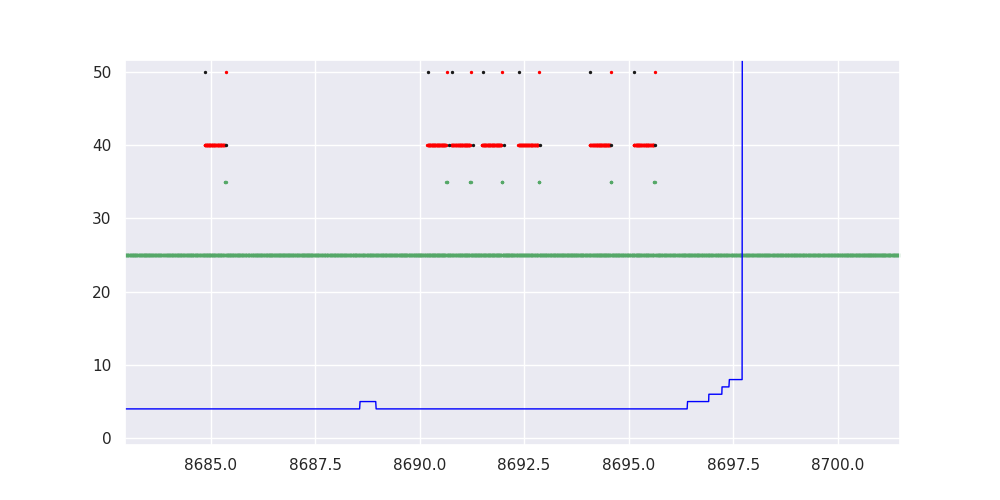

In [41]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [52]:
stim_message1[stim_message1['ripple_end']==1]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,1,126605850,126606194,126606240,1.577059e+09,0,0,0,99,0.5,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11,3471,138074550,138075595,138075700,1.577060e+09,1,1,10,0,0.5,...,1,0.906853,0.008242,0.007692,0.061933,0.015279,0.0,0.0,0.0,0.0
22,3724,138383400,138384158,138384300,1.577060e+09,1,2,10,4,0.5,...,1,0.014089,0.019722,0.025151,0.033837,0.907201,0.0,0.0,0.0,0.0
33,3749,138390450,138390715,138390800,1.577060e+09,1,3,10,4,0.5,...,1,0.027573,0.034600,0.028070,0.051067,0.858690,0.0,0.0,0.0,0.0
54,3990,138633900,138634854,138634940,1.577060e+09,0,4,20,99,0.5,...,1,0.195683,0.174938,0.157852,0.242158,0.229369,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,82279,199151250,199157060,199157160,1.577062e+09,0,838,9,99,0.5,...,1,0.514029,0.055288,0.273203,0.095474,0.062005,0.0,0.0,0.0,0.0
10688,82312,199179750,199180052,199180240,1.577062e+09,1,839,10,0,0.5,...,1,0.670729,0.003119,0.004404,0.004048,0.317700,0.0,0.0,0.0,0.0
10722,82410,199189350,199194377,199194440,1.577062e+09,0,841,33,3,0.5,...,1,0.180104,0.047266,0.116917,0.522499,0.133214,0.0,0.0,0.0,0.0
10741,82455,199218300,199218944,199219120,1.577062e+09,0,842,18,3,0.5,...,1,0.020768,0.015887,0.296846,0.508768,0.157730,0.0,0.0,0.0,0.0


In [59]:
stim_message1[10705:10715]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
10705,82349,199186500,199186694,199186880,1.577062e+09,0,840,17,99,0.5,...,1,0.051556,0.021081,0.216927,0.688206,0.022230,0.0,0.0,0.0,0.0
10706,82350,199186650,199186835,199187020,1.577062e+09,0,840,18,99,0.5,...,1,0.056618,0.021921,0.187224,0.708634,0.025603,0.0,0.0,0.0,0.0
10707,82351,199186800,199186996,199187060,1.577062e+09,0,840,19,99,0.5,...,1,0.054837,0.023364,0.192904,0.700891,0.028004,0.0,0.0,0.0,0.0
10708,82359,199186950,199187194,199187300,1.577062e+09,0,840,20,99,0.5,...,1,0.099402,0.028695,0.165799,0.649894,0.056210,0.0,0.0,0.0,0.0
10709,82370,199187100,199187273,199188180,1.577062e+09,0,841,21,99,0.5,...,1,0.071620,0.031247,0.179995,0.653514,0.063624,0.0,0.0,0.0,0.0
10710,82372,199187250,199187441,199188260,1.577062e+09,0,841,22,99,0.5,...,1,0.085884,0.027732,0.149108,0.669808,0.067468,0.0,0.0,0.0,0.0
10711,82373,199187400,199187598,199188280,1.577062e+09,0,841,23,99,0.5,...,1,0.056406,0.021168,0.148298,0.700635,0.073493,0.0,0.0,0.0,0.0
10712,82374,199187550,199187713,199188400,1.577062e+09,0,841,24,99,0.5,...,1,0.061908,0.021905,0.133331,0.711492,0.071364,0.0,0.0,0.0,0.0
10713,82378,199187700,199187959,199188480,1.577062e+09,0,841,25,99,0.5,...,1,0.051074,0.024564,0.140960,0.713077,0.070325,0.0,0.0,0.0,0.0
10714,82383,199187850,199188055,199188520,1.577062e+09,0,841,26,99,0.5,...,1,0.035442,0.012394,0.130820,0.751616,0.069728,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


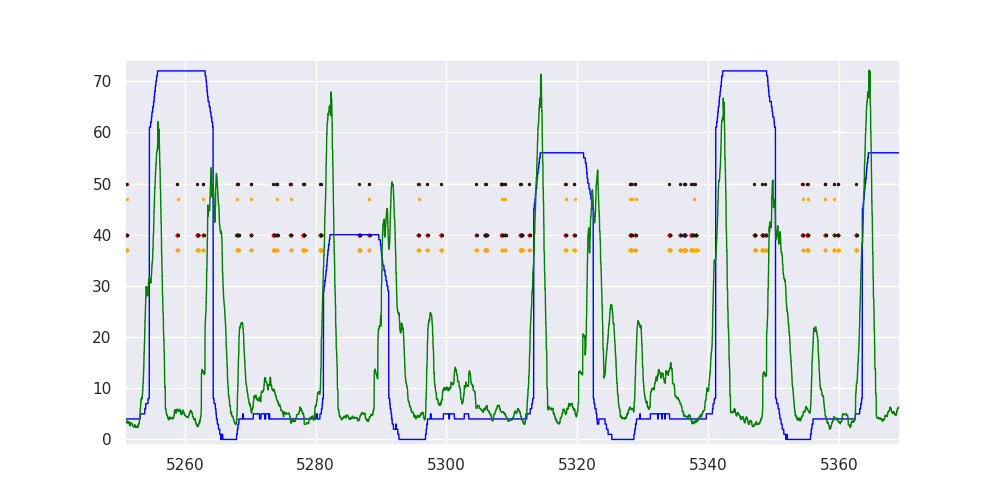

In [51]:
# look at time delay for stim message with new posterior sum function

plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['velocity'].values)*1)/1),c='green',linewidth=1)


#realtime ripples: stim message
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message1['lfp_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+37,c='orange',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


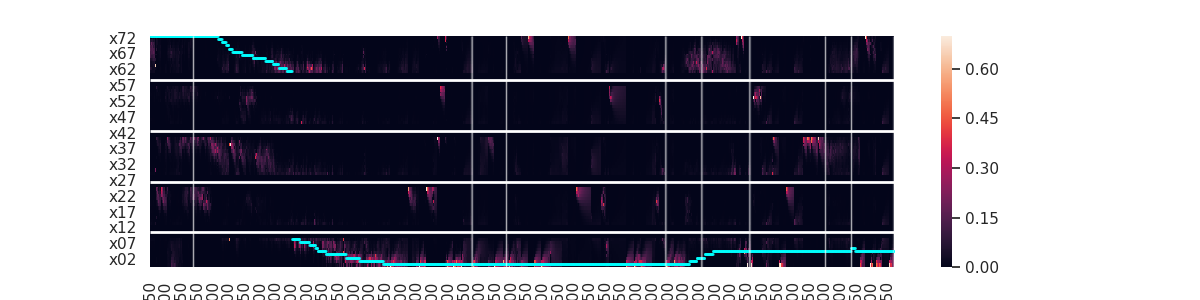

In [33]:
%matplotlib notebook
# all tetrodes (21) for full session on drought, 150 uV threshold, good linearization, adjusted TS
# 20 tetrodes for full session on drought, 150 uV threshold, adjusted timestamps
# realtime arm ends: 1, 17, 33, 49, 65, 81, 97, 113, 129
# new arm ends: 7, 23, 39, 55, 71, 87, 103, 119, 135
import seaborn as sns
sns.set()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
#this value is currently just emprically set
#ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1958800
#closest value lookup, return row
#decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
#for i in np.arange(1,ripple_timestamps.shape[0]):
#    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
#    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
#decoder_ripple_times
#decoder_ripple_list = decoder_ripple_times.index.tolist()

#posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only_merged.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(12,3))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
ax.scatter(np.arange(0,merged_to_plot.shape[0]),72-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
#ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
ax.vlines(ripple_times,lw=1,color='w',alpha=0.3,*ax.get_ylim())
# some how need to convert sent_message_list into values starting where beginning of this plot is x=0
#ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())


In [ ]:
#plot realtime data no ripple
import seaborn as sns
sns.set()

posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())

# save posterior heatmap for all ripples - realtime

In [ ]:
# make indivudal posterior heatmap for each detected ripple
# shifted realtime rips back 70 msec to take care of delay in detection
# to match offline: +/- 100 msec after trigger
# also plot end of posterior lockout to see how much of the ripple is missed by sum
# loop through timestamp for each ripple and generate a new slice of decoder data
# plot that slice then save image

(array([ 0., 22., 11.,  8., 17., 43., 48., 52.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

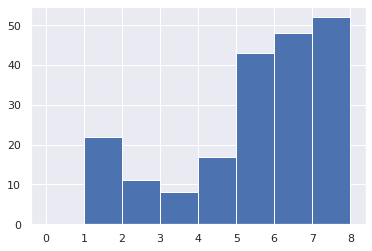

In [71]:
plt.hist(stim_message['posterior_max_arm'].values,bins=np.arange(0,9))

In [167]:
#plt.hist(stim_message2['posterior_max_arm'].values,bins=np.arange(0,9))
stim_message2[stim_message2['posterior_max_arm']==99]
stim_message2[140:150]
target_time = 80766160
stim_message2[(stim_message2['lfp_timestamp']>target_time-200000) & (stim_message2['lfp_timestamp']<target_time+200000)]


,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,spike_count,posterior_max_arm,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
182,122079,80593200,80593360,80593440,1.580672e+09,0,154,1,5,0,...,1,0.968147,0.000813,0.006544,0.000502,0.000851,0.005418,0.006296,0.009275,0.002155
183,122173,80617650,80617988,80618020,1.580672e+09,0,155,1,1,0,...,1,0.918858,0.005445,0.011303,0.000960,0.002369,0.004687,0.004474,0.010212,0.041692
184,122578,80761500,80761665,80761740,1.580672e+09,1,156,1,3,7,...,1,0.052384,0.023777,0.298800,0.002287,0.003019,0.047482,0.013506,0.557120,0.001625
185,122629,80766000,80766172,80766200,1.580672e+09,0,157,1,7,0,...,1,0.782780,0.078628,0.136533,0.000029,0.000107,0.000185,0.000947,0.000764,0.000029
186,122801,80814450,80814674,80814760,1.580672e+09,0,158,1,5,0,...,1,0.788240,0.042204,0.036477,0.111869,0.002478,0.000612,0.000671,0.014541,0.002908
187,122821,80817300,80817459,80817560,1.580672e+09,1,158,20,76,8,...,1,0.271207,0.053294,0.002368,0.001031,0.005538,0.000443,0.042822,0.057184,0.566114
188,123011,80885850,80886026,80886100,1.580672e+09,0,159,1,8,0,...,1,0.678107,0.012744,0.002105,0.040394,0.005941,0.026760,0.189625,0.023187,0.021137
189,123111,80919450,80919614,80919680,1.580672e+09,0,160,1,2,0,...,1,0.901241,0.000518,0.000608,0.001295,0.000588,0.000910,0.001456,0.044300,0.049084
190,123259,80964600,80965060,80965520,1.580672e+09,0,161,1,4,0,...,1,0.941381,0.000746,0.000810,0.004589,0.001620,0.002936,0.034682,0.011770,0.001465


In [164]:
stim_lockout2[stim_lockout2['lockout_state']>0][157:162]

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
467,122077,80593400,3.979147,157,1,2,0
470,122166,80617880,3.989685,158,1,2,0
473,122575,80761640,5.375251,159,1,2,0
475,122627,80766160,5.409420,160,1,3,0
479,122800,80814760,4.062650,161,1,2,0


In [112]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
# stim_lockout timestamp_shift is the 70 msec shift to account for delay in realtime rip detection (-2100)

stim_message_1 = stim_message2.copy()
stim_message_2 = stim_message_1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message_2
decode_to_merge = decoder_data2.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message_2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout2.copy()
stim_lockout_1['timestamp_shift'] = stim_lockout2['timestamp']-2100
#stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_1['bin_timestamp'] = stim_lockout_1['timestamp_shift']

stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout.shape

(264122, 167)

In [165]:
timestamp = 80766160
merge_subset = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                      (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
#merge_subset['posterior_max_arm'].values
#merge_subset['lockout_num'].values
merge_subset['lockout_state'].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

80760160 80772160
(105, 137)
80808760 80820760
(105, 137)
80880040 80892040
(94, 137)
80913620 80925620
(96, 137)
80958920 80970920
(104, 137)
81043700 81055700
(108, 137)
81068140 81080140
(106, 137)
81185720 81197720
(107, 137)
81190340 81202340
(114, 137)
81196060 81208060
(113, 137)


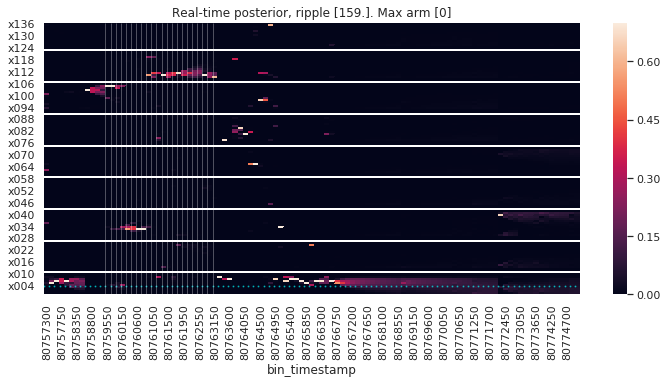

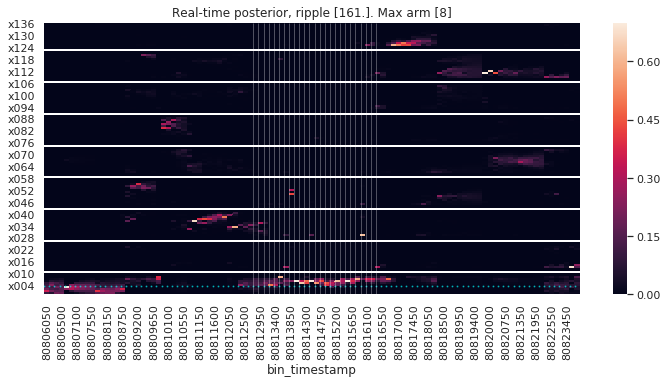

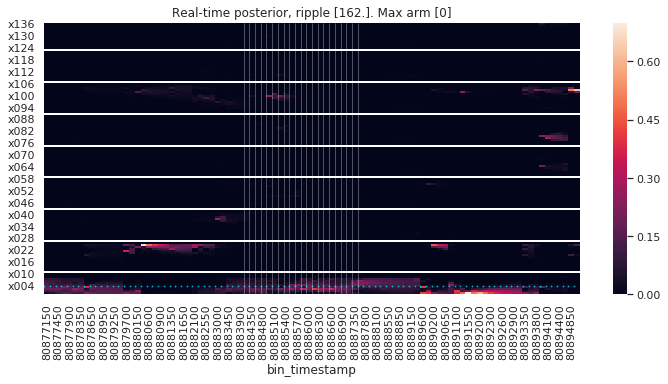

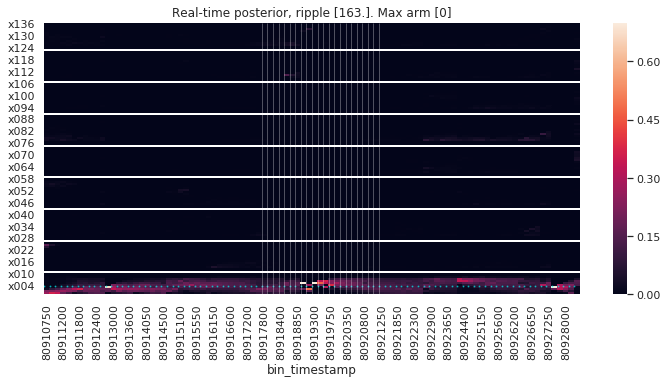

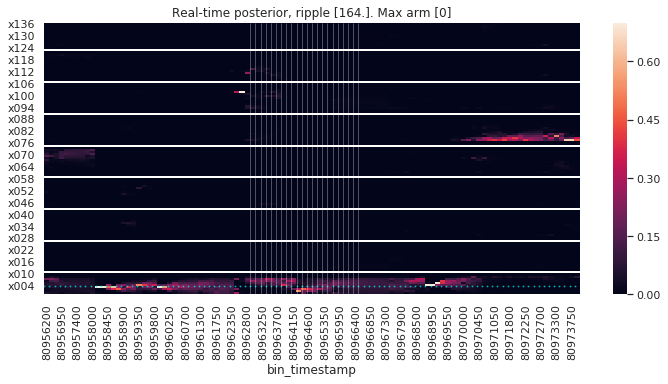

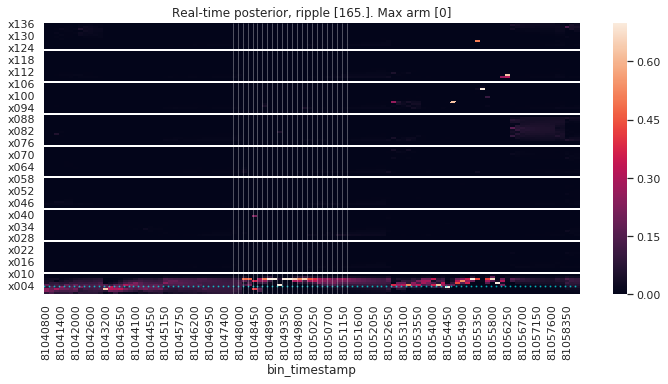

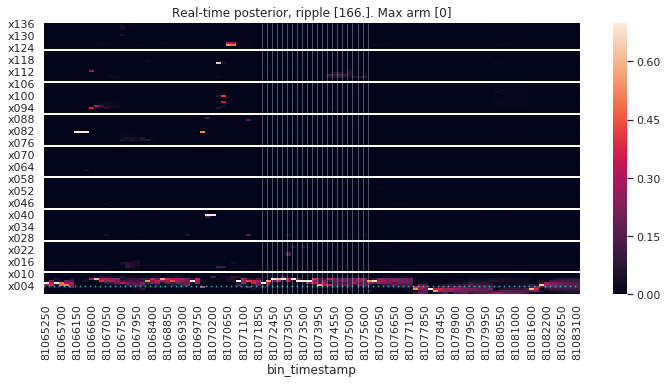

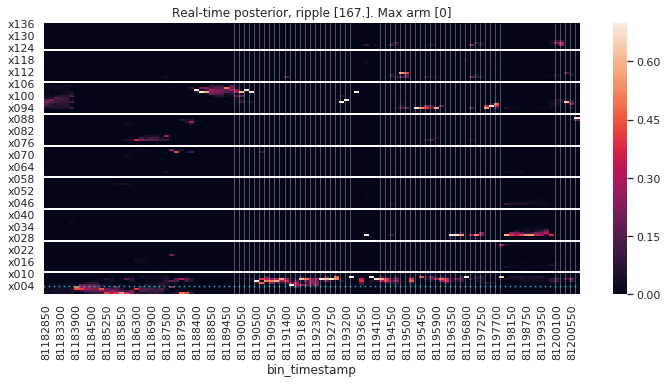

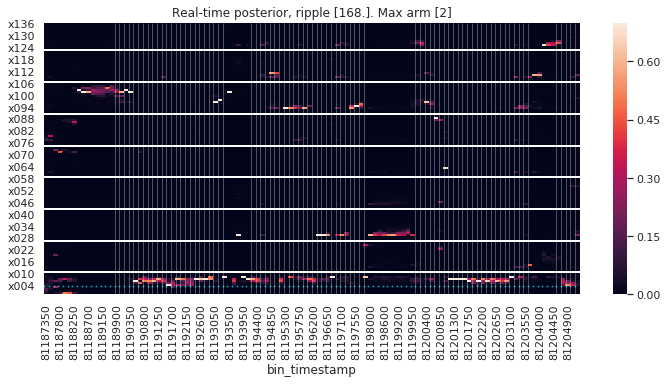

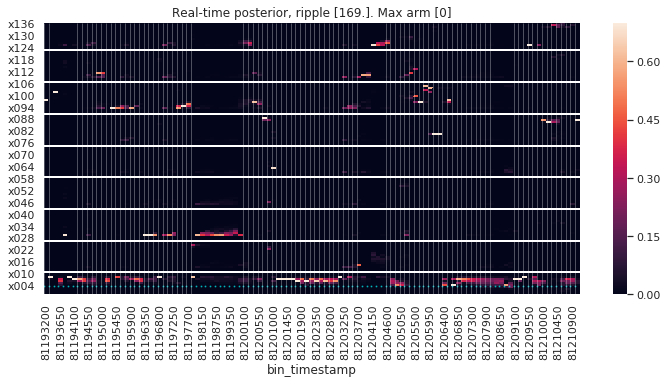

In [163]:
# subset of decoder_data to plot - loop through each ripple
for timestamp in stim_lockout2[stim_lockout2['lockout_state']==1]['timestamp'][160:170].values:
    print(timestamp-30*200,timestamp+30*200)
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length','timestamp_shift',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #plot title: include ripple number and max arm
    max_arm_index = int(len(merged_to_plot)*0.6)
    max_arm = merged_to_plot[max_arm_index:max_arm_index+1]['posterior_max_arm'].values
    #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
    #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
    ripple_num_index = int(len(merged_to_plot)*0.6)
    #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
    ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['lockout_num'].values

    
    plt.figure(figsize=(12,5))
    plt.title(f'Real-time posterior, ripple {ripple_num}. Max arm {max_arm}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
    # try to find ripple number
    #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')

    # need to convert sent_message_list into values starting where beginning of this plot is x=0
    #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
    # final step: save the figure
    #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/1-30-20/remy_20_2_realtime_1_30_shifted_ripple_{ripple_num}_timestamp_{timestamp}.jpg')

# check numbering for ripples 4, 5, 6
# also, looks like it never switch to an outer arm if the decode starts in the box
# looks like many replays fail because it doesn't get 10 bins of data - this may be a result of empty bins

In [97]:
# with new decoder: one bin time delay for dropped spikes
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
# stim_lockout timestamp_shift is the 70 msec shift to account for delay in realtime rip detection (-2100)

stim_message_1 = stim_message1.copy()
stim_message2 = stim_message_1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data1.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout1.copy()
stim_lockout_1['timestamp_shift'] = stim_lockout1['timestamp']-2100
#stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_1['bin_timestamp'] = stim_lockout_1['timestamp_shift']

stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout1 = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout1.shape

(356319, 168)

In [ ]:
stim_lockout[stim_lockout['lockout_state']==1][100:110]

In [ ]:
stim_lockout1[stim_lockout1['lockout_state']==1][100:110]

71082140 71094140
(61, 137)
71087520 71099520
(64, 137)
71187340 71199340
(58, 137)


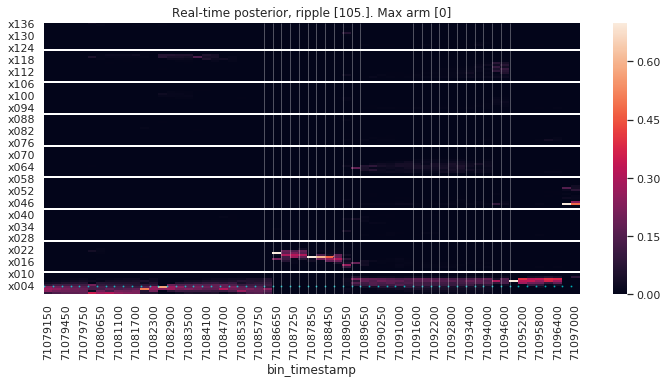

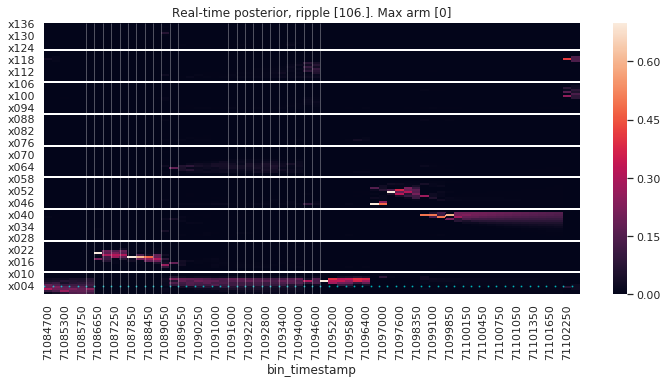

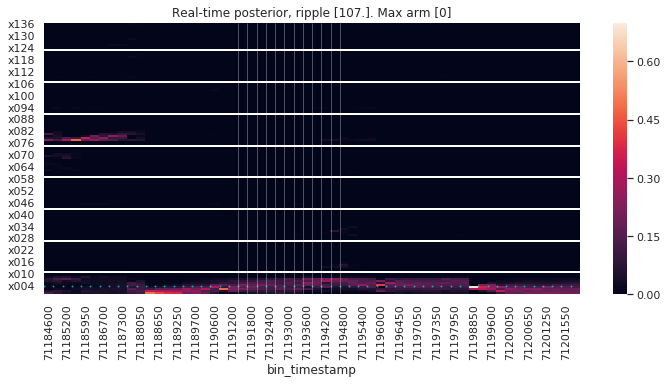

In [106]:
# subset of decoder_data to plot - loop through each ripple
for timestamp in stim_lockout1[stim_lockout1['lockout_state']==1]['timestamp'][105:108].values:
    print(timestamp-30*200,timestamp+30*200)
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout1[(merged_decoder_lockout1['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout1['bin_timestamp'] < timestamp+30*300)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos','next_bin',
                                                'spike_count','ripple','ripple_length','timestamp_shift',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #plot title: include ripple number and max arm
    max_arm = merged_to_plot[-2:-1]['posterior_max_arm'].values
    #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
    #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
    ripple_num_index = int(len(merged_to_plot)*0.5)
    #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
    ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['lockout_num'].values

    
    plt.figure(figsize=(12,5))
    plt.title(f'Real-time posterior, ripple {ripple_num}. Max arm {max_arm}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
    # try to find ripple number
    #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')

    # need to convert sent_message_list into values starting where beginning of this plot is x=0
    #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
    # final step: save the figure
    #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/1-30-20/remy_20_2_realtime_1_30_shifted_ripple_{ripple_num}_timestamp_{timestamp}.jpg')

# check numbering for ripples 4, 5, 6
# also, looks like it never switch to an outer arm if the decode starts in the box
# looks like many replays fail because it doesn't get 10 bins of data - this may be a result of empty bins

In [ ]:
stim_lockout[stim_lockout['lockout_state']==1][0:5]

In [ ]:
# 30 mins - better replau annotation, no next bin


In [10]:
# to match offline, add 1958987 to realtime timestamps
# shift for realtime ripple detection delay: subtract 2100
#45317550 45321300

realtime_rips = stim_lockout[stim_lockout['lockout_state']==1]
offline_rips = rips.reset_index()
offline_rips['adj_timestamp'] = offline_rips['timestamp']
realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1958987-2100
realtime_rips
# merge real-time and offline ripples 
# tolerance is in timestamps, so 60000 is 2 seconds - this gets us 383 of 459 - i think this is way too big
# offline ripple start is 50-100 msec before real-time
# try a tolerance of 200 msec for nearest match (6000 timestamps) 100 msec = 3000 timestamps
merged_ripple_times = pd.merge_asof(offline_rips,realtime_rips,on='adj_timestamp',tolerance=3000,direction='nearest')
matching_offline_rips = merged_ripple_times[merged_ripple_times['lockout_num']>0]

In [11]:
matching_offline_rips.shape

(202, 15)

(array([  6., 148.,  45.,   2.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

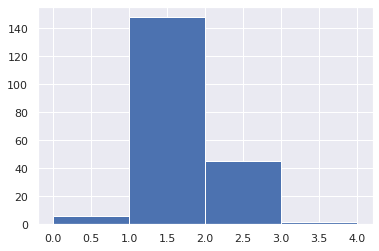

In [12]:
# shows number of offline ripples that match two realtime ripples (duplicates)
# look at value of 0 bin in histogram (23)
plt.hist(matching_offline_rips['lockout_num'].diff().values,bins=np.arange(0,5))

In [ ]:
post_sum_times.iloc[:,4:150]
post_sum_end = np.around(post_sum_ripple[-1:],decimals=2)
post_sum_end = post_sum_end[0]
print(f'Off{post_sum_end}')


In [57]:
post_sum_ripple[7:14]

array([[5.08856473e-01, 6.88667412e+00, 1.88217386e-03, 8.69286236e-04,
        2.93908939e-03, 4.66486384e-01, 1.09969357e-01, 2.40241674e-03,
        1.88360580e-02],
       [5.08870709e-01, 7.88663615e+00, 1.88230127e-03, 8.69288941e-04,
        2.93908939e-03, 4.66488981e-01, 1.09969359e-01, 2.40241676e-03,
        1.88360581e-02],
       [5.08870836e-01, 8.88655582e+00, 1.88241438e-03, 8.71313979e-04,
        2.93918866e-03, 4.66488981e-01, 1.09969361e-01, 2.40331796e-03,
        1.88360586e-02],
       [5.13836812e-01, 9.82443203e+00, 2.66974861e-03, 7.51457610e-03,
        6.77734422e-03, 4.79303276e-01, 1.11061487e-01, 3.43683800e-03,
        4.85681382e-02],
       [5.29983857e-01, 1.06545787e+01, 7.62439625e-03, 3.60370684e-02,
        1.90379097e-02, 5.06359585e-01, 1.15707502e-01, 8.82467488e-03,
        1.17863922e-01],
       [5.59916109e-01, 1.15028233e+01, 1.14056205e-02, 5.37047522e-02,
        3.59159300e-02, 5.33162543e-01, 1.24303890e-01, 1.73997654e-02,
        1.5

In [62]:
ripple_num[0]
test_array = np.zeros((7,9))
#test_array[0,:]
for i in np.arange(0,14):
    test_array[np.mod(i,7),:] = post_sum_ripple[i]
print(np.around(np.sum(test_array,axis=0),decimals=1))
np.around(test_array,decimals=1)
#post_sum_ripple.shape
#np.mod(7,7)

[ 3.2 56.5  0.   0.1  0.1  3.   0.7  0.   0.4]


array([[ 0.5,  6.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  7.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  8.9,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5,  9.8,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0. ],
       [ 0.5, 10.7,  0. ,  0. ,  0. ,  0.5,  0.1,  0. ,  0.1],
       [ 0.6, 11.5,  0. ,  0.1,  0. ,  0.5,  0.1,  0. ,  0.2],
       [ 0. ,  0.8,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ]])

In [ ]:
# offline posteriors, 150 uV threshold
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
arm_coords = [[0,8],[13,25],[30,42],[47,59],[65,77],[82,94],[99,111],[116,128],[133,145]]

posterior_offline = posteriors2.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')

for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_x']):
    print(rip_timestamp-30*300,rip_timestamp+30*300,index)

    posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > rip_timestamp-30*300) & 
                                            (merged_off_post_pos['timestamp'] < rip_timestamp+30*300)]

    realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
    ripple_num_index = int(len(posterior_to_plot)*0.55)
    ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values
    
    # calculate posterior sum during ripple
    # we need to only take out the time when ripple_grp matches ripple_grp at the middle of the plotting bin
    
    #post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]
    post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] == ripple_num[0]]
    ripple_length = post_sum_times.shape[0]
    # sum each arm over whole ripple
    post_sum_ripple = np.zeros((ripple_length,9))
    for i in np.arange(0,ripple_length):
        if i == 0:
            for j in np.arange(0,len(arm_coords),1):
                post_sum_ripple[i,j] = post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()

        else:
            for j in np.arange(0,len(arm_coords),1):
                post_sum_ripple[i,j] = post_sum_ripple[i-1,j] + post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()
            
    # normalize sum of whole ripple - this is the final row
    post_sum_ripple[i] = post_sum_ripple[i]/post_sum_ripple[i].sum()
    
    ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

    posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

    posterior_offline2 = posterior_offline1.fillna(0)
    post_heatmap = posterior_offline2.transpose()
    post_heatmap = post_heatmap.iloc[::-1]

    posterior_sum = np.around(post_sum_ripple[-1:],decimals=1)
    posterior_sum = posterior_sum[0]

    plt.figure(figsize=(15,5))
    plt.title(f'Off rip {ripple_num}. RT rip {realtime_ripple_num} {posterior_sum}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
    ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())
    
    # final step: save the figure
    plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/1-30-20/remy_20_2_offline_rip_{ripple_num}_real_rip_{realtime_ripple_num}_timestamp_{rip_timestamp}.jpg')




In [ ]:
decoder_data[0:10]
#likelihood_only = likelihood_data.iloc[:, 5:]


In [125]:
from ipywidgets import interact
@interact(i=(0, 1000))
def _plot(i=0):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(posterior_only_merged.iloc[i])
    axes[1].plot(likelihood_only.iloc[i])

interactive(children=(IntSlider(value=0, description='i', max=1000), Output()), _dom_classes=('widget-interact…

(1174, 137)


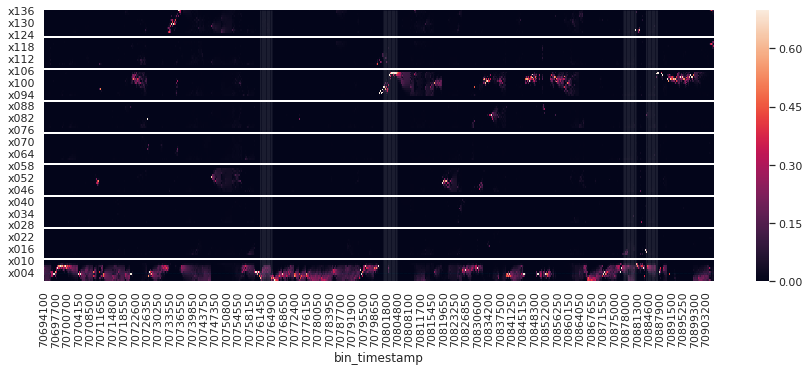

In [153]:
    # plot single realtime ripple
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > 70700060-30*200) & 
                                            (merged_decoder_lockout['bin_timestamp'] < 70900060+30*200)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    plt.figure(figsize=(15,5))
    #plt.title(f'Real-time posterior, ripple {ripple_num}. Max arm {max_arm}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.01,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times,lw=1,color='w',alpha=0.05,*ax.get_ylim())

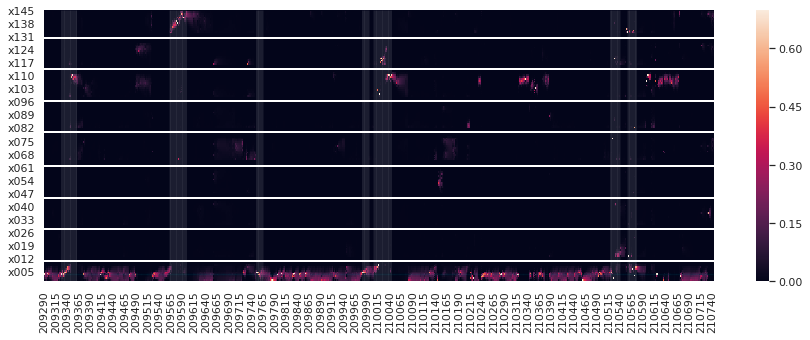

In [154]:
    # plot single offline ripple
    posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > 70700060+1958987-30*300) & 
                                            (merged_off_post_pos['timestamp'] < 70900060+1958987+30*300)]

    ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

    posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

    posterior_offline2 = posterior_offline1.fillna(0)
    post_heatmap = posterior_offline2.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
    #ripple_num_index = int(len(posterior_to_plot)*0.6)
    #ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values 

    plt.figure(figsize=(15,5))
    #plt.title(f'Offline posterior, offline rip {ripple_num}. Realtime rip {realtime_ripple_num}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=0.01,color='cyan')
    ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.05,*ax.get_ylim())

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(offline_pos['timestamp'][0:3000].values,offline_pos['linpos_flat'][0:3000].values, s=4)
plt.scatter(merged_offline_posterior_pos['timestamp'][0:20000].values,merged_offline_posterior_pos['linpos_flat'][0:20000].values, s=2, alpha=0.05)


In [135]:
# ripple from real-time timestamps: 87475500 - 87585000
stim_lockout[(stim_lockout['timestamp']>87475500) & (stim_lockout['timestamp']<87585000)]

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
398,119886,87478860,4.668738e+00,199,1,2,1
399,119897,87482620,1.580166e+09,199,0,0,1


In [102]:
realtime_rips
decoder_data
trials_timestamp = trials.copy()
trials_timestamp

starttime      endtime
day epoch trial                          
20  2     0      1375.220333  1524.100333
          1      1524.100333  1581.400333
          2      1581.400333  1618.258333
          3      1618.258333  1646.974333
          4      1646.974333  1697.465333
...                      ...          ...
          104    5314.083333  5335.145333
          105    5335.145333  5366.125333
          106    5366.125333  5410.345333
          107    5410.345333  5449.408333
          108    5449.408333  5483.735333

[109 rows x 2 columns]

In [118]:
trials_timestamp['start_ts'] = trials_timestamp['starttime']*30000
trials_timestamp['end_ts'] = trials_timestamp['endtime']*30000
trials_timestamp
rips

<RippleTimes: 79c5aeab-0a63-4e84-9deb-80f490b22e1e, shape: ((1256, 4))>

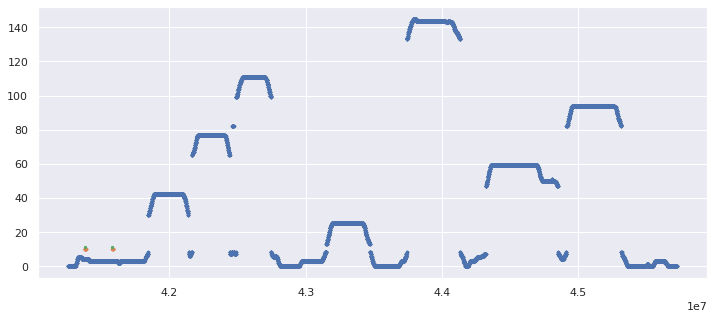

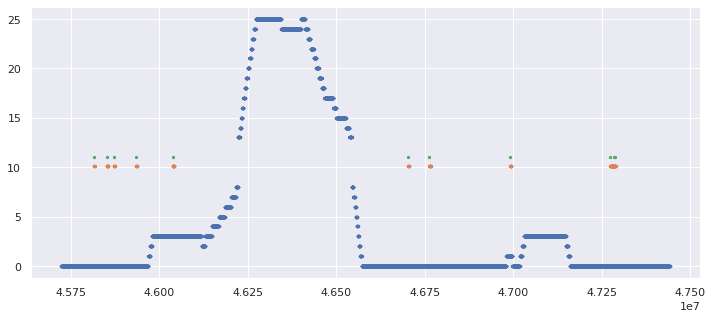

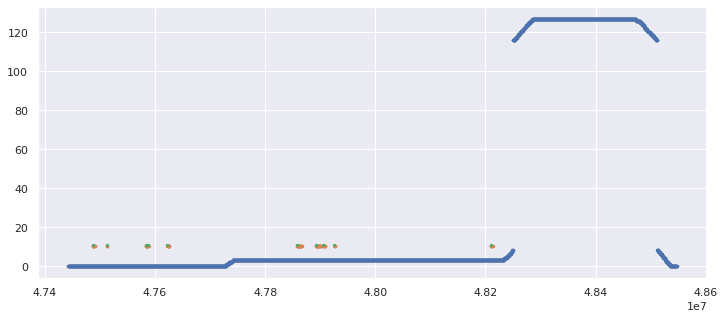

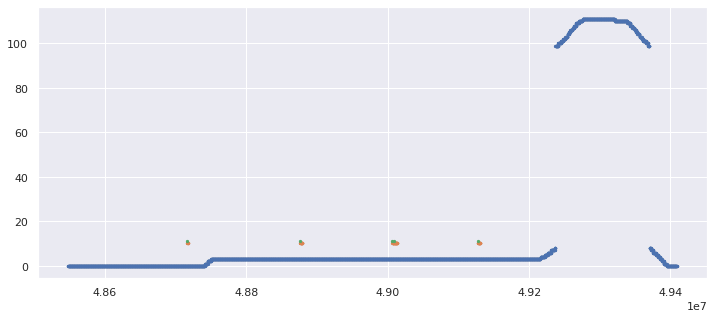

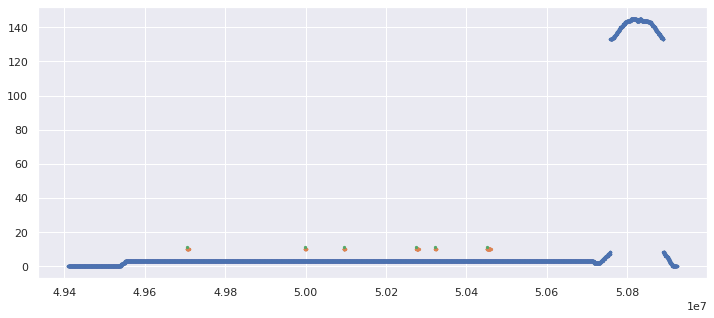

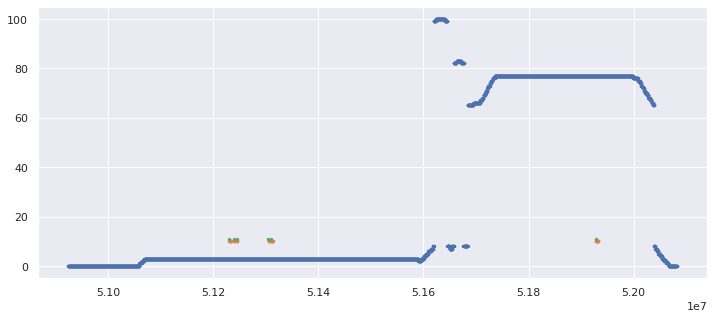

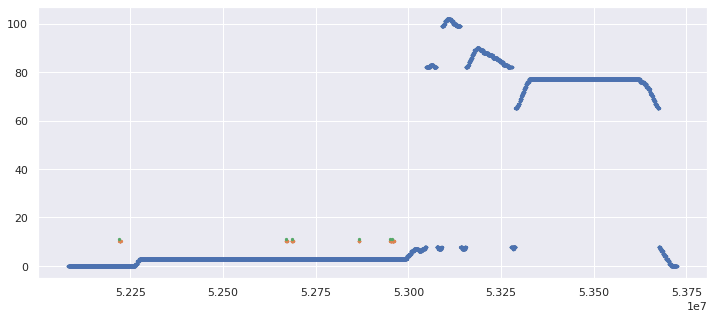

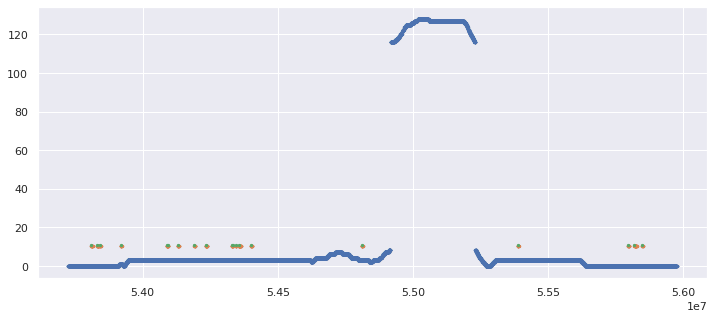

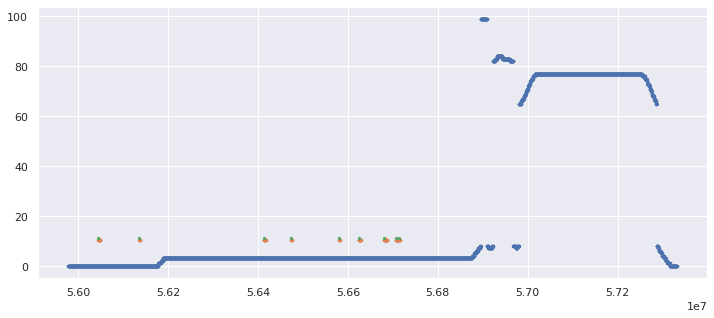

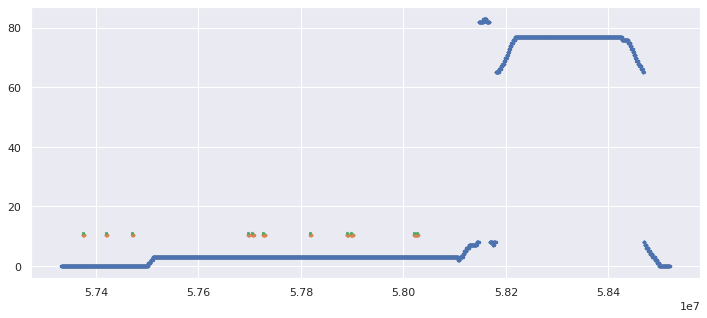

In [123]:
#plotting to check ripple detection offline and realtime

for i in np.arange(0,10):
    trial_start = trials_timestamp['start_ts'][i:i+1].values[0]
    trial_end = trials_timestamp['end_ts'][i:i+1].values[0]
    trial_post = merged_off_post_pos[(merged_off_post_pos['timestamp'].values > trial_start) & (merged_off_post_pos['timestamp'].values < trial_end)]
    trial_post_rips = trial_post[trial_post['ripple_grp']>0]
    all_rips = rips.reset_index()
    all_rips_plot = all_rips[(all_rips['timestamp'].values > trial_start) & (all_rips['timestamp'].values < trial_end)]
    plt.figure(figsize=(12,5))
    plt.scatter(trial_post['timestamp'].values,trial_post['linpos_flat'].values,s=5)
    plt.scatter(trial_post_rips['timestamp'].values,(trial_post_rips['ripple_grp'].values/1000)+10,s=5)
    plt.scatter(all_rips_plot['timestamp'].values,np.repeat(11,len(all_rips_plot)),s=5)


In [122]:
np.repeat(11,len(all_rips_plot))

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [62]:
#calculate max for offline posteriors
post_to_merge = posteriors2.copy()

#calculate posterior max
post_to_merge1 = post_to_merge.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_to_merge1.fillna(0,inplace=True)
post_to_merge1['posterior_max'] = post_to_merge1.idxmax(axis=1)
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].str.replace('x','')
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].astype(int)

#post_to_merge.reset_index(level=['timestamp'],inplace=True)
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']

#calculate posterior max

#post_to_merge.set_index('timestamp', append=True, inplace=True)
#post_to_merge.set_index('dat','epoch','timestamp', 'time',append=True, inplace=True)
#post_to_merge1 = post_to_merge.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
post_to_merge1

pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)

posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')
posterior_with_pos_vel['error_cm'] = abs(posterior_with_pos_vel['posterior_max']-posterior_with_pos_vel['linpos_flat'])*5
posterior_with_pos_vel

post_error_plot_off = posterior_with_pos_vel.copy()
#post_error_plot_off = post_error_plot[100:821700]
post_error_plot_off = post_error_plot_off[post_error_plot_off['linvel_flat']>4]
post_error_plot_off.shape

(194133, 155)

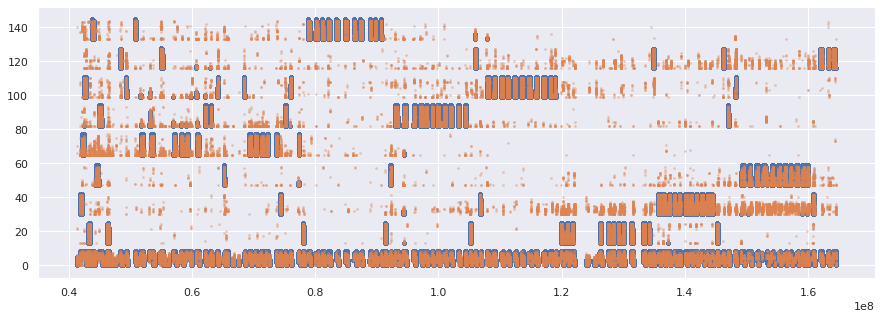

In [63]:
#offline position and decoded position
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


In [ ]:
list(decoder_data3)

In [64]:
# for real-time posterior
post_error1 = decoder_data.copy()
#post_error1 = likelihood_data.copy()

post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','velocity','real_pos','spike_count','ripple',
                          'ripple_number','ripple_length','shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                          'arm6','arm7','arm8','raw_x','raw_y','smooth_x','smooth_y'],inplace=True)

#post_error1.drop(columns=['rec_ind','timestamp','real_pos_time','real_pos','spike_count','ripple',
#                          'box','arm1','arm2','arm3','arm4','arm5',
#                          'arm6','arm7','arm8'],inplace=True)

#post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','real_pos','spike_count'],inplace=True)

post_error1.fillna(0,inplace=True)
post_error1['max_position'] = post_error1.idxmax(axis=1)
post_error1['max_position'] = post_error1['max_position'].str.replace('x','')
post_error1['max_position'] = post_error1['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error1['timestamp'] = decoder_data['bin_timestamp']
post_error1['real_vel'] = decoder_data['velocity']
post_error1['real_pos'] = decoder_data['real_pos']
post_error1['spike_count'] = decoder_data['spike_count']
#this is the error column in centimeters
post_error1['error_cm'] = abs(post_error1['max_position']-decoder_data['real_pos'])*5

post_error1.shape
post_error_plot_realtime = post_error1[post_error1['real_vel']>8]
post_error_plot_realtime.shape

(164469, 143)

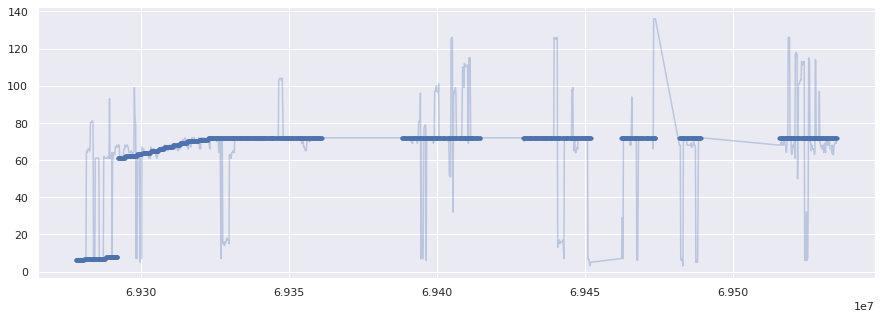

In [119]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# new trodes (12-19)
plt.figure(figsize=(15,5))
time_slice = slice(94000, 95000)
plt.scatter(post_error_plot_realtime['timestamp'][time_slice].values,
            post_error_plot_realtime['real_pos'][time_slice].values,s=10)
plt.plot(post_error_plot_realtime['timestamp'][time_slice].values,
         post_error_plot_realtime['max_position'][time_slice].values,alpha=0.3)


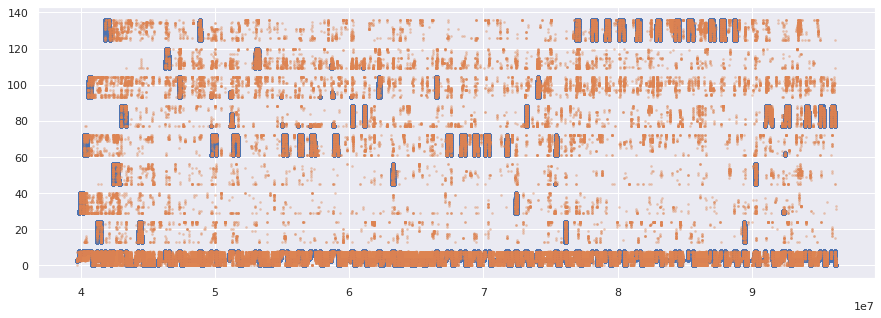

In [281]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# OLD TRODES
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['real_pos'].values,s=10)
plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['max_position'].values,s=3,alpha=0.3)


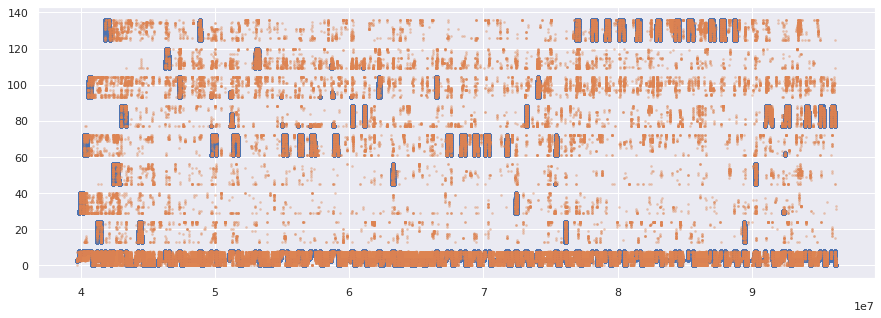

In [65]:
# remy day 20 epoch 2 realtime - westerlies
# 150 uV, 19 tets, no timer
# OLD TRODES
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['real_pos'].values,s=10)
plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['max_position'].values,s=3,alpha=0.3)


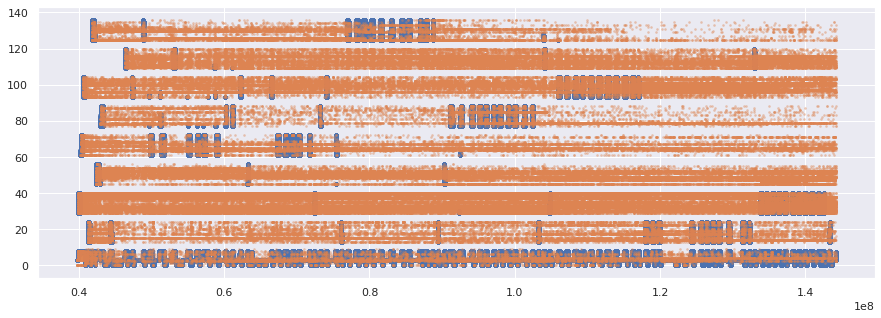

In [143]:
# remy day 20 epoch 2 realtime - likelihoods
# 150 uV, 15 tets, no timer
plt.figure(figsize=(15,5))

plt.scatter(post_error1['timestamp'].values,post_error1['real_pos'].values,s=10)
plt.scatter(post_error1['timestamp'].values,post_error1['max_position'].values,s=3,alpha=0.3)


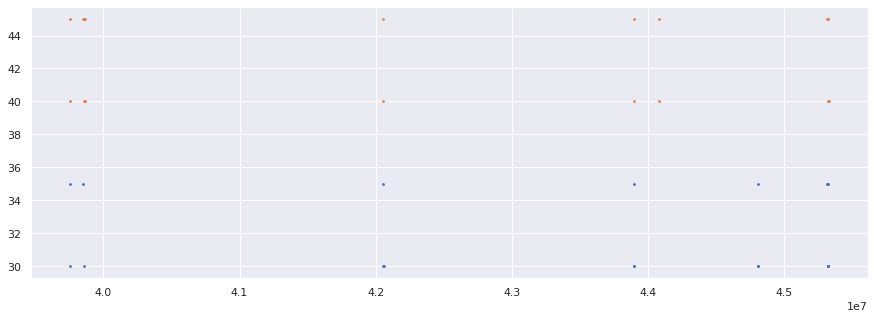

In [288]:
# ripples in old trodes 30 min decode westerlies vs previous one
# note: different velocity threshold
# stim_lockout: 10 cm/sec (15 tets on greenflash)
# stim_lockout19: 8 cm/sec (19 tets on westerlies)
# need to apply velocity threshold to offline ripples too - yes it is already applied

plt.figure(figsize=(15,5))

plt.scatter(stim_lockout['timestamp'][0:20].values,stim_lockout['lockout_state'][0:20].values*5+30,s=3)
plt.scatter(stim_lockout19['timestamp'][0:20].values,stim_lockout19['lockout_state'][0:20].values*5+40,s=3)

<IPython.core.display.Javascript object>


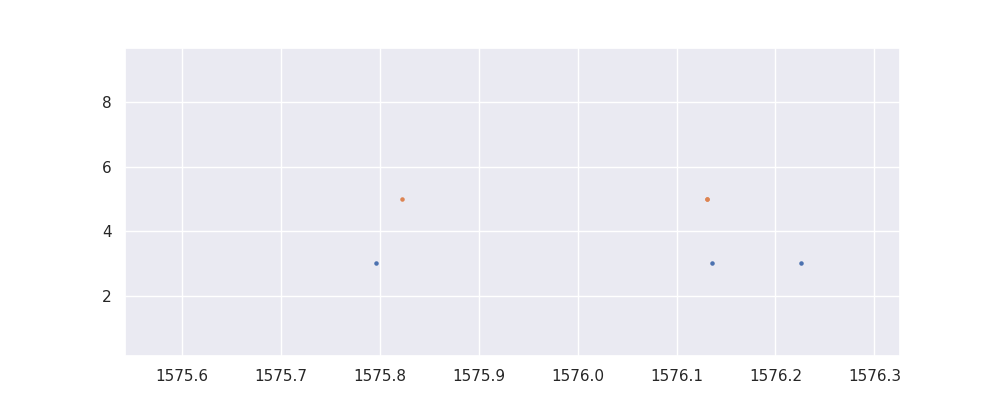

(0, 10)

In [194]:
%matplotlib notebook
# see how far before realtime rip detection to set posterior sum
# plot realtime and offline rip starts
plt.figure(figsize=(10,4))
plt.scatter(matching_offline_rips['timestamp_x'].values/30000,np.repeat(3, 202),s=5)
plt.scatter((matching_offline_rips['timestamp_y'].values+1958987-2100)/30000,np.repeat(5, 202),s=5)
plt.ylim([0,10])
#matching_offline_rips.shape

<IPython.core.display.Javascript object>


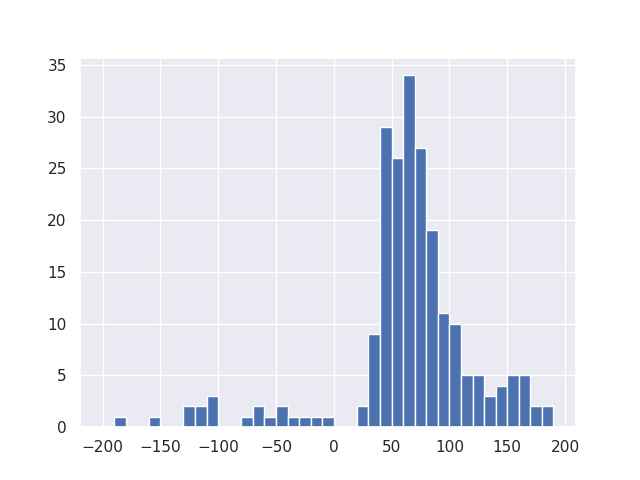

(array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  3.,  0.,  0.,  1.,
         2.,  1.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  2.,  9., 29., 26.,
        34., 27., 19., 11., 10.,  5.,  5.,  3.,  4.,  5.,  5.,  2.,  2.]),
 array([-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,
         -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,
          20,   30,   40,   50,   60,   70,   80,   90,  100,  110,  120,
         130,  140,  150,  160,  170,  180,  190]),
 <a list of 39 Patch objects>)

In [171]:
#histogram of delay in realtime ripple compared to offline
# result: most common time delay is 60-70 msec, with the 150-250 Hz filter and SD = 5 with Anna's baseline values
# this delay will probably need to be calculated for each new animal / day
# for the analysis no, let use 70 msec as the shift and see how that works
# so for posterior sum, we want 70 msec before stim lockout and 50 msec after
plt.hist(((matching_offline_rips['timestamp_y'].values+1958987)-
          matching_offline_rips['timestamp_x'].values)/30,bins=np.arange(-200,200,10))


In [159]:
matching_offline_rips

,day,epoch,event,timestamp_x,starttime,endtime,maxthresh,adj_timestamp,rec_ind,timestamp_y,time,lockout_num,lockout_state,tets_above_thresh,big_rip_message_sent
19,20,2,66,45852404,1528.413467,1528.517467,6.582024,45852404,10541.0,43895760.0,0.745635,5.0,1.0,2.0,1.0
22,20,2,69,46038044,1534.601467,1534.742133,3.670240,46038044,11010.0,44082520.0,6.087636,6.0,1.0,2.0,1.0
26,20,2,86,47273884,1575.796133,1576.112800,10.921949,47273884,14100.0,45317800.0,5.746183,7.0,1.0,2.0,1.0
27,20,2,87,47284084,1576.136133,1576.206133,4.838653,47284084,14127.0,45327040.0,7.470352,9.0,1.0,2.0,1.0
28,20,2,88,47286764,1576.225467,1576.290800,2.473105,47286764,14127.0,45327040.0,7.470352,9.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,20,2,972,96823943,3227.464800,3227.620800,4.975869,96823943,138451.0,94868840.0,5.986134,244.0,1.0,2.0,1.0
509,20,2,973,96828744,3227.624800,3227.921467,12.799470,96828744,138451.0,94868840.0,5.986134,244.0,1.0,2.0,1.0
513,20,2,991,97665543,3255.518133,3255.810800,15.995828,97665543,140564.0,95711360.0,3.849507,247.0,1.0,2.0,1.0
514,20,2,995,97987884,3266.262800,3266.331467,3.618805,97987884,141364.0,96029740.0,3.790184,249.0,1.0,2.0,1.0


In [195]:
stim_message3[stim_message3['shortcut_message_sent']>0]
stim_message3[0:10]
shortcut_message_to_plot = stim_message3[(stim_message3['bin_timestamp'] > timestamp-30*300) & 
                                         (stim_message3['bin_timestamp'] < timestamp+30*300)]
print(timestamp)
shortcut_message_to_plot
merged_to_plot_index = merged_to_plot.reset_index()
# want to return index in merged_to_plot for bin_timestamp in shortcut_message_to_plot
merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()


75870540


[33]

In [227]:
index_test[0]
merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
shortcut_message_to_plot['shortcut_message_sent'].values


array([0, 1])

In [226]:
shortcut_message_to_plot
#shortcut_message_to_plot['shortcut_message_sent'].values*100
#stim_message3[10:20]
index_test = np.zeros(shortcut_message_to_plot.shape[0])
for i in np.arange(0,shortcut_message_to_plot.shape[0]):
    print(shortcut_message_to_plot['bin_timestamp'][i:i+1].values)
    index_test[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
index_test
#shortcut_message_to_plot.shape[0]

[77259000]
[77262450]


array([34., 49.])

In [194]:
merged_to_plot['shortcut_message_sent'].values
#for timestamp in stim_lockout3[stim_lockout3['lockout_state']==1]['timestamp'][10:15].values:
#    print(timestamp)
merged_to_plot.reset_index()[30:40]

,bin_timestamp,rec_ind,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x135,x136,shortcut_message_sent,ripple_number_y,delay,posterior_max_arm,ripple_end,lockout_num,lockout_state,timestamp_shift
30,75868950,22436,1.580754e+09,5.545489,3.0,667.0,389.0,666.5177,389.7246,0,...,8.545270e-04,8.545270e-04,1,14,30.333333,6,1,14.0,1.0,75868440.0
31,75869400,22438,1.580754e+09,5.545489,3.0,667.0,389.0,666.5177,389.7246,2,...,7.457659e-13,7.457659e-13,1,14,30.333333,6,1,14.0,1.0,75868440.0
32,75869850,22441,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,3,...,4.178165e-09,4.178165e-09,1,14,30.333333,6,1,14.0,1.0,75868440.0
33,75870150,22444,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,2,...,8.193522e-14,8.193522e-14,1,14,30.333333,6,1,14.0,1.0,75868440.0
34,75870300,22446,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,0,...,9.896112e-05,9.896112e-05,1,14,30.333333,6,1,14.0,1.0,75868440.0
35,75870450,22448,1.580754e+09,5.299752,3.0,667.0,389.0,666.5259,389.6897,0,...,1.968941e-04,1.968941e-04,1,14,30.333333,6,1,14.0,1.0,75868440.0
36,75870900,22450,1.580754e+09,5.097650,3.0,666.0,389.0,666.4954,389.6552,2,...,1.025571e-10,1.025571e-10,1,14,30.333333,6,1,14.0,1.0,75868440.0
37,75871200,22452,1.580754e+09,5.097650,3.0,666.0,389.0,666.4954,389.6552,1,...,1.575434e-08,1.575434e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0
38,75871500,22454,1.580754e+09,4.995355,3.0,666.0,390.0,666.4652,389.6603,2,...,3.650851e-08,3.650851e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0
39,75871950,22456,1.580754e+09,4.963294,3.0,666.0,390.0,666.4355,389.6657,2,...,3.213001e-08,3.213001e-08,1,14,30.333333,6,1,14.0,1.0,75868440.0


In [174]:
# check new ripple numbering
stim_message_1 = stim_message3.copy()
stim_message_2 = stim_message_1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message_2
decode_to_merge = decoder_data3.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message_2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout3.copy()
stim_lockout_1['timestamp_shift'] = stim_lockout3['timestamp']-2100
stim_lockout_1['bin_timestamp'] = stim_lockout_1['timestamp_shift']

stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout.shape

(28072, 169)

73668260 73686260
(89, 137)
73672680 73690680
(91, 137)
73726360 73744360
(81, 137)
73730120 73748120
(77, 137)
73748960 73766960
(85, 137)
73863200 73881200
(79, 137)
74394400 74412400
(85, 137)
74398920 74416920
(79, 137)
74512500 74530500
(69, 137)
74525440 74543440
(79, 137)
74539680 74557680
(85, 137)
75065900 75083900
(71, 137)
75228120 75246120
(80, 137)
75552420 75570420
(98, 137)
75861540 75879540
(79, 137)
76337240 76355240
(80, 137)
76433960 76451960
(86, 137)
76571760 76589760
(89, 137)
76594000 76612000
(86, 137)
77250340 77268340
(72, 137)
77473700 77491700
(84, 137)
77837280 77855280
(87, 137)
78759100 78777100
(83, 137)
78802440 78820440
(75, 137)
78808060 78826060
(68, 137)
78975660 78993660
(74, 137)
79023860 79041860
(91, 137)


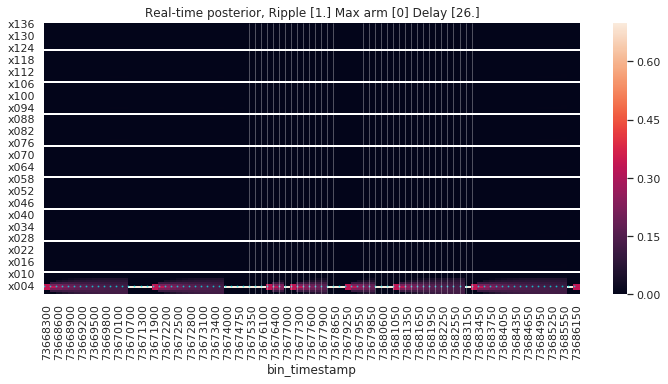

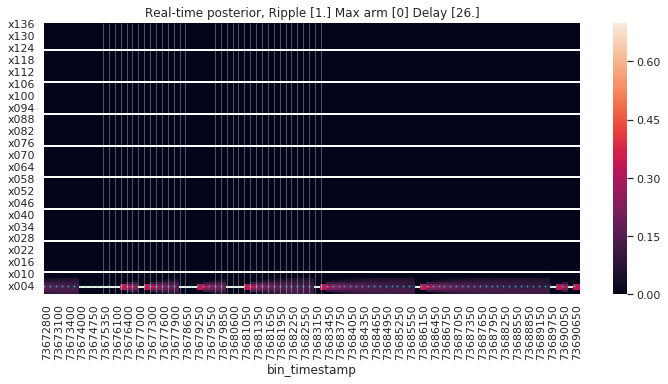

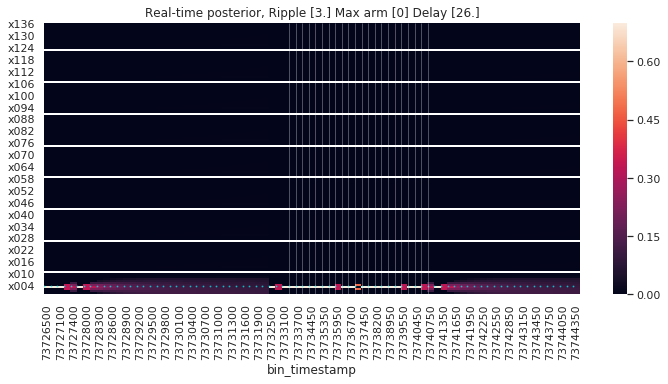

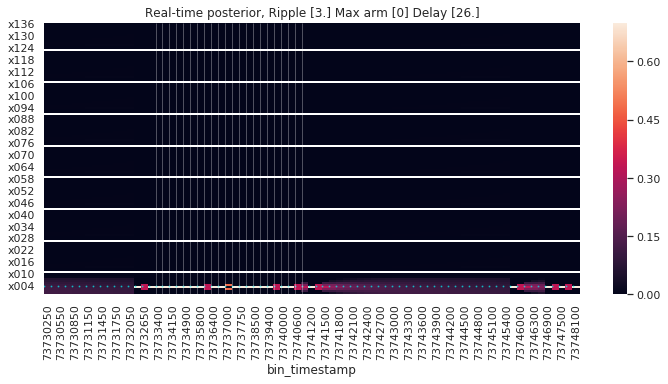

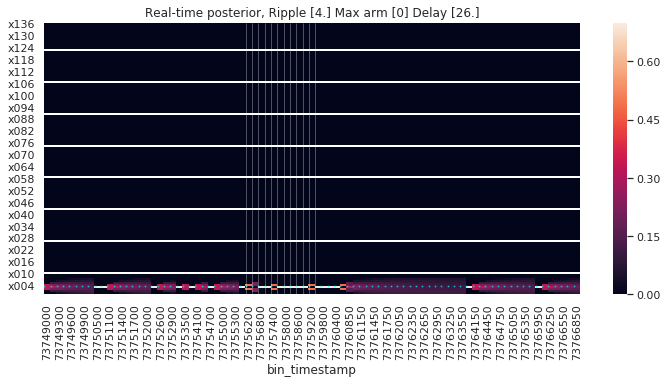

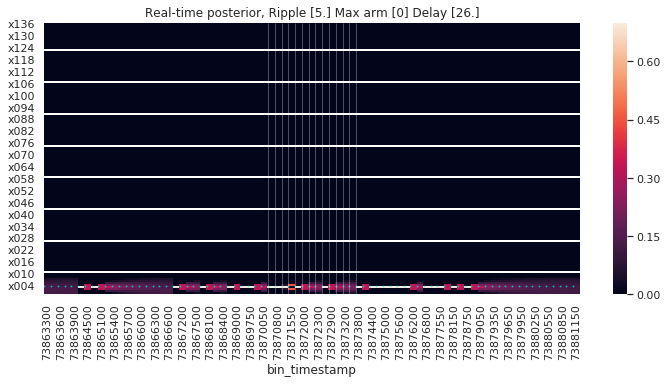

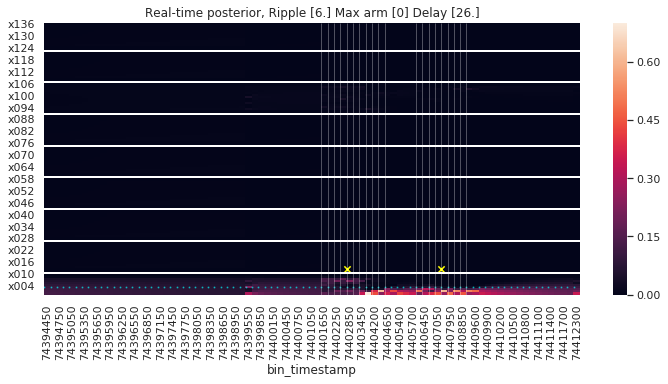

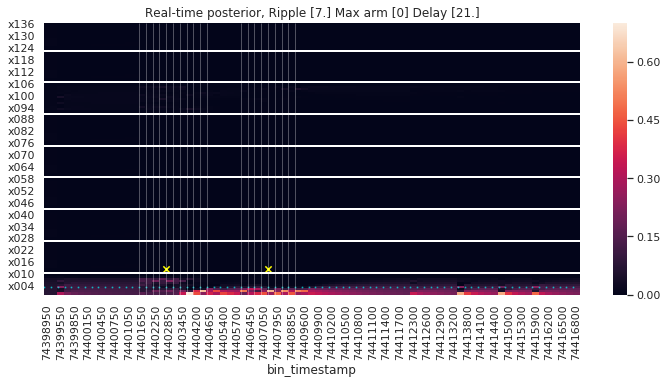

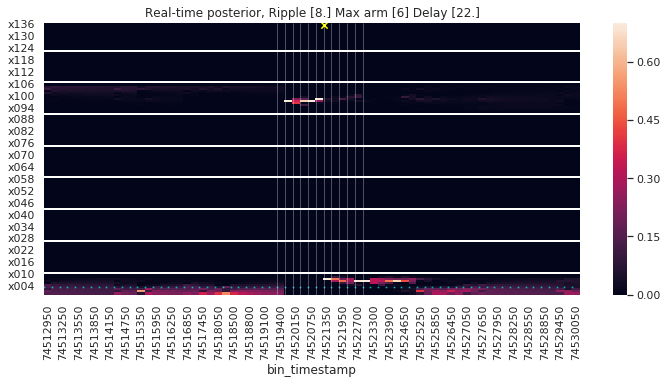

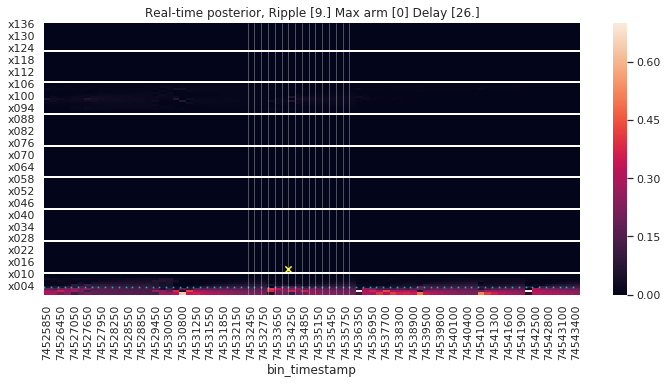

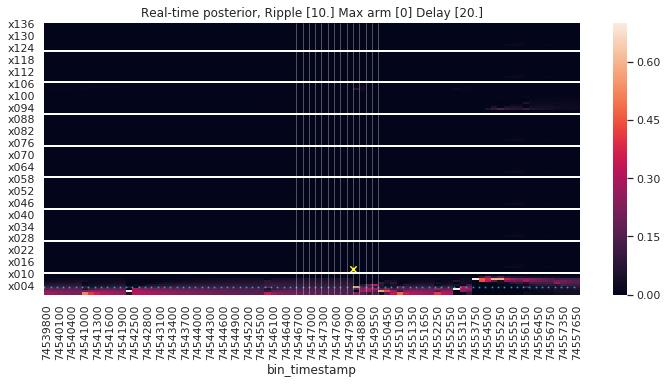

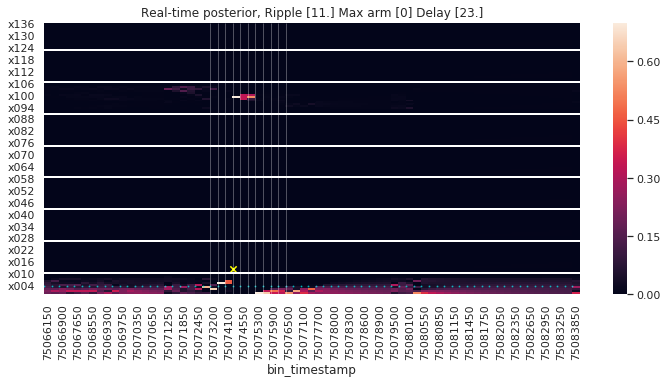

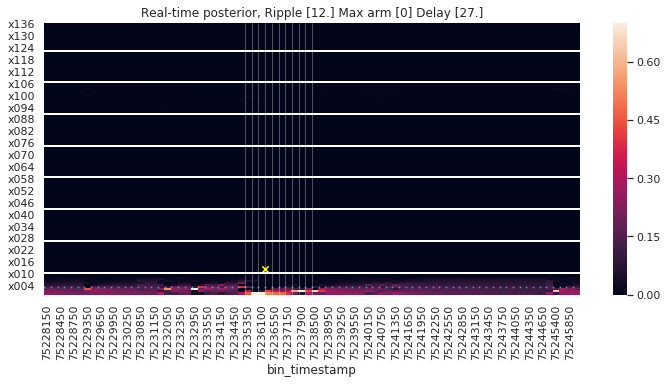

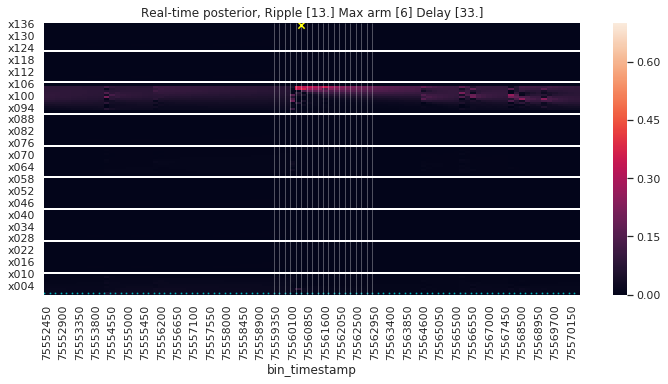

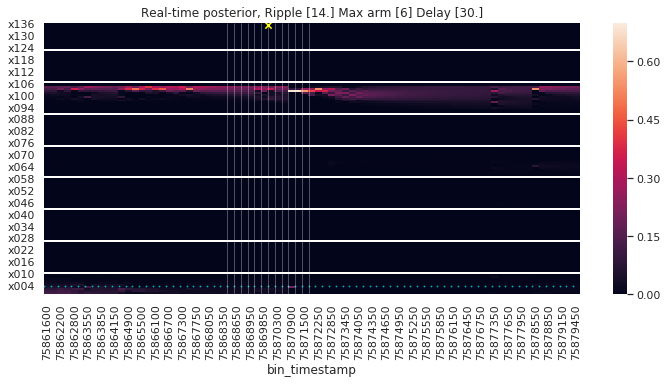

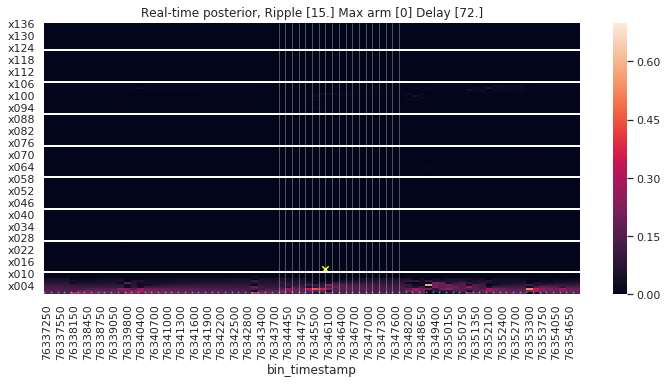

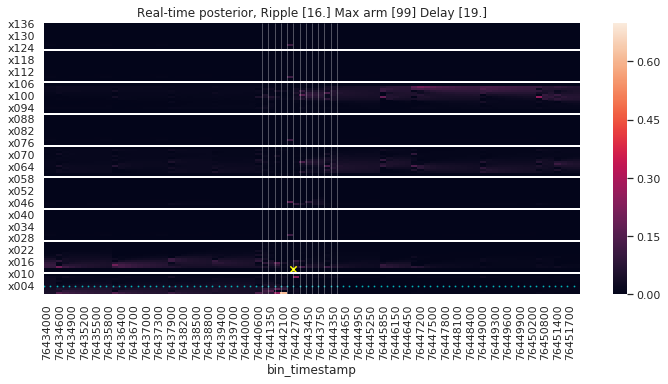

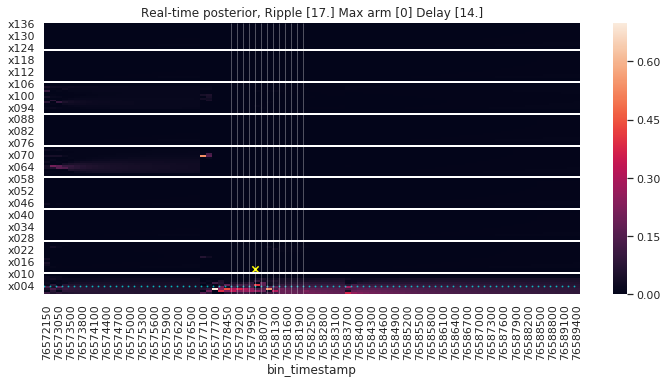

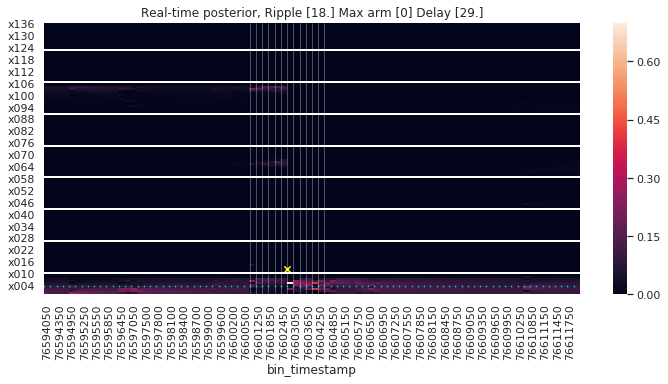

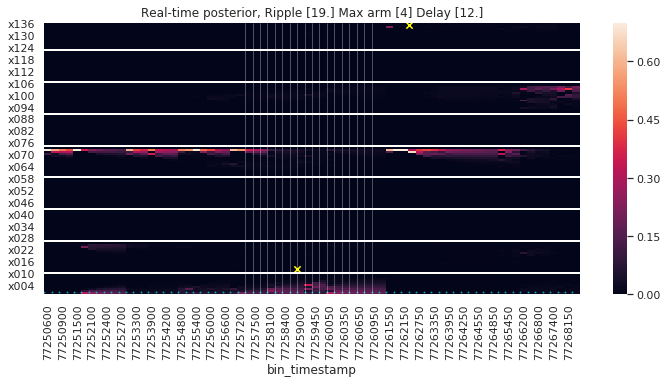

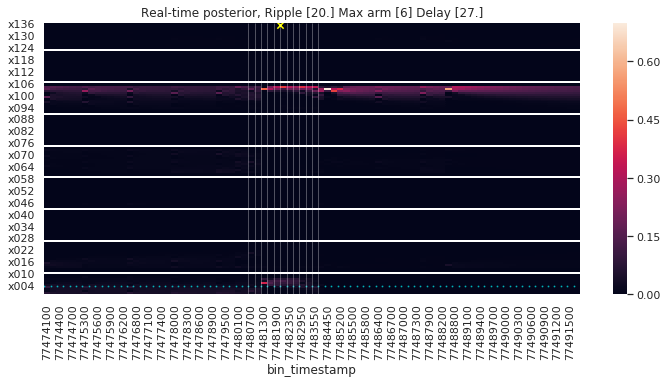

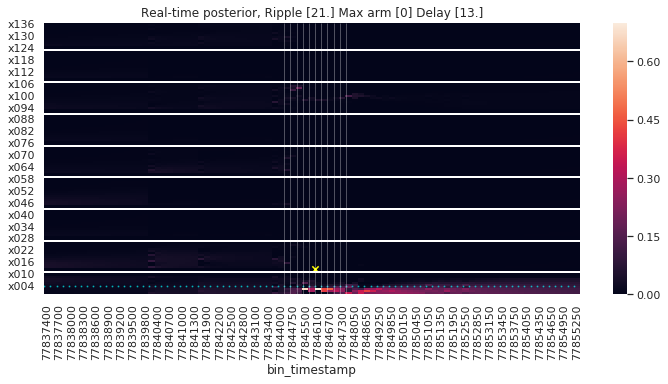

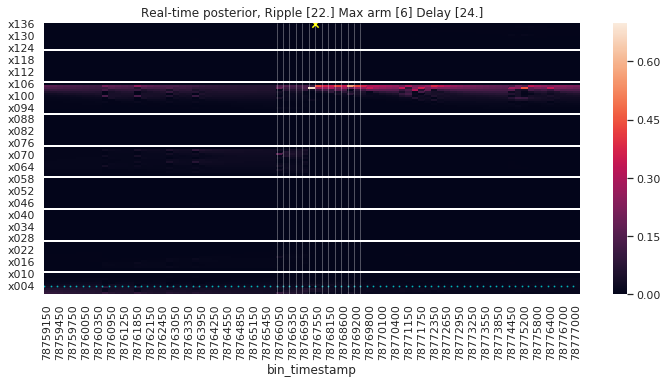

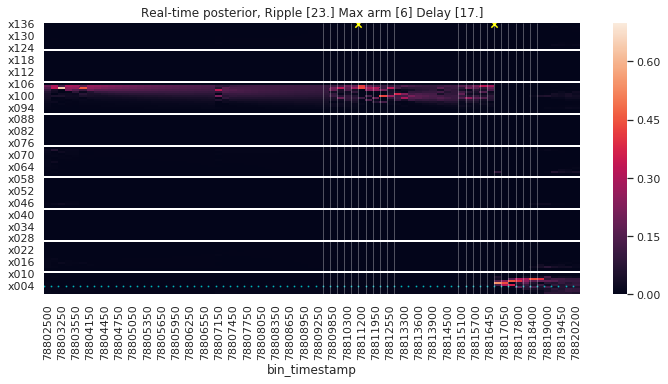

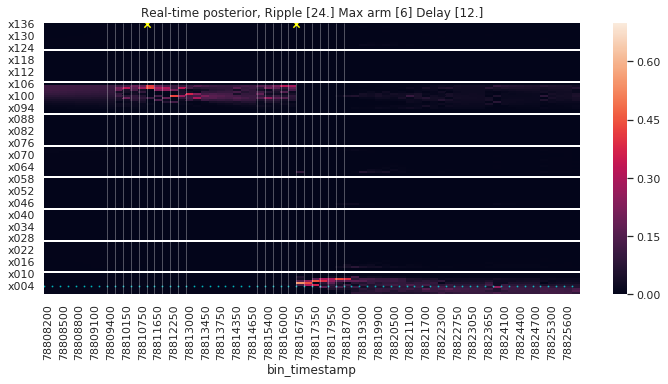

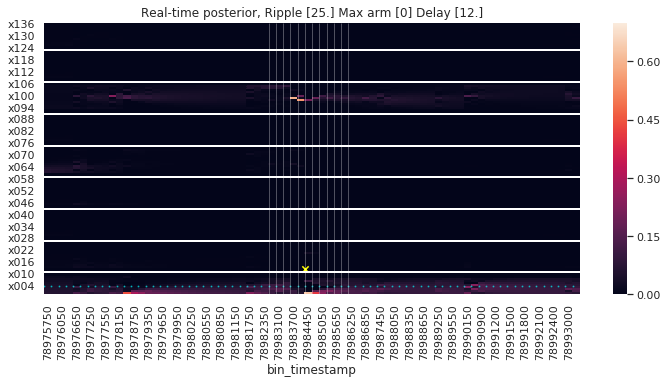

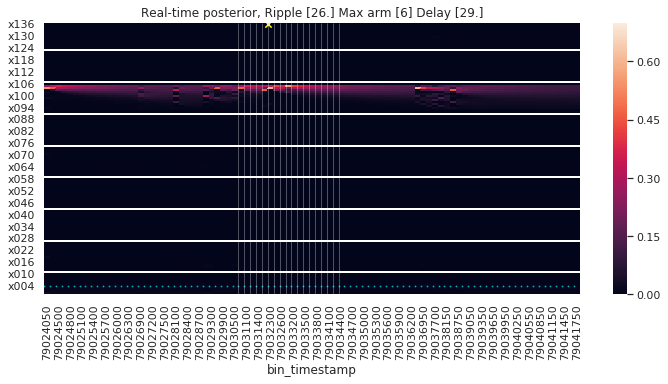

In [238]:
# check new ripple numbering
# subset of decoder_data to plot - loop through each ripple
for timestamp in stim_lockout3[stim_lockout3['lockout_state']==1]['timestamp'].values:
    print(timestamp-30*300,timestamp+30*300)
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length','timestamp_shift',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num',
                                                'delay','next_bin'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    # get timestamp when shortcut message was sent
    shortcut_message_to_plot = stim_message3[(stim_message3['bin_timestamp'] > timestamp-30*300) & 
                                             (stim_message3['bin_timestamp'] < timestamp+30*300)]
    merged_to_plot_index = merged_to_plot.reset_index()
    # loop through multiple entries in shortcut_message
    shortcut_message_times = np.zeros(shortcut_message_to_plot.shape[0])
    for i in np.arange(0,shortcut_message_to_plot.shape[0]):
        shortcut_message_times[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]

    #shortcut_message_times = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()
    shortcut_messages = shortcut_message_to_plot['shortcut_message_sent'].values*123
    
    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #plot title: include ripple number, max arm, and delay
    title_index = int(len(merged_to_plot)*0.6)
    max_arm = merged_to_plot[title_index:title_index+1]['posterior_max_arm'].values
    #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
    #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
    #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
    ripple_num = merged_to_plot[title_index:title_index+1]['lockout_num'].values
    message_delay = np.around(merged_to_plot[title_index:title_index+1]['delay'].values,decimals=0)

    
    plt.figure(figsize=(12,5))
    plt.title(f'Real-time posterior, Ripple {ripple_num} Max arm {max_arm} Delay {message_delay}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
    # plot time when statescript message was sent, 100 = sent, 0 = not send
    ax.scatter(shortcut_message_times,124-shortcut_messages,s=40,color='yellow',marker='x')
    # try to find ripple number
    #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')
